In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
import networkx as nx
import numpy as np

from dowhy import gcm
from dowhy import CausalModel

warnings.filterwarnings("ignore")

## Problem Statement

It is worth reminding ourselves the questions that we want to solve

1. What affects total value the most?
2. Do promotion/discounts pricing/holiday/weekend play affect total unit count and values? If so, how much? Can we model this?
3. Can we explain what is causing the huge spike in anomalous days?
4. Can we explain what affects NPS/customer satisfaction?
5. Does our overall marketing spending change the overall sales value? 

### Answering marketing and NPS

There probably won't be anything strong to conclude here given that the data is quite rough. 

We will measure 
1. If the individual marketing category affects total demand
2. If the total spending affects each  marketing category differently. 


In [59]:
marketing_data = pd.read_csv('./month_data.csv')

In [79]:
marketing_columns = ['dig','traditional','Sponsorship','Affiliates','Other','Total.Investment']
category_columns = ['AudioMP3Player_Lower', 'AudioMP3Player_Upper',
       'CameraAccessory', 'Camera_Camcorders', 'Camera_DSLR',
       'Camera_Instant Cameras', 'Camera_Point & Shoot',
       'Camera_SportsAndAction', 'Game_Lower', 'Game_Upper', 'GamingAccessory',
       'GamingConsole_GamingConsole_Lower',
       'GamingConsole_GamingConsole_Upper',
       'GamingConsole_HandheldGamingConsole_Lower',
       'GamingConsole_HandheldGamingConsole_Upper', 'GamingHeadset',
       'HomeAudio', 'SmallAudio_Lower', 'SmallAudio_Upper', 'Speaker']


We note that the contribution to total revenue is uneven. The highest contribution comes from two categories: DSLRs and Speakers

<Axes: title={'center': '% of total revenue'}, ylabel='% of revenue'>

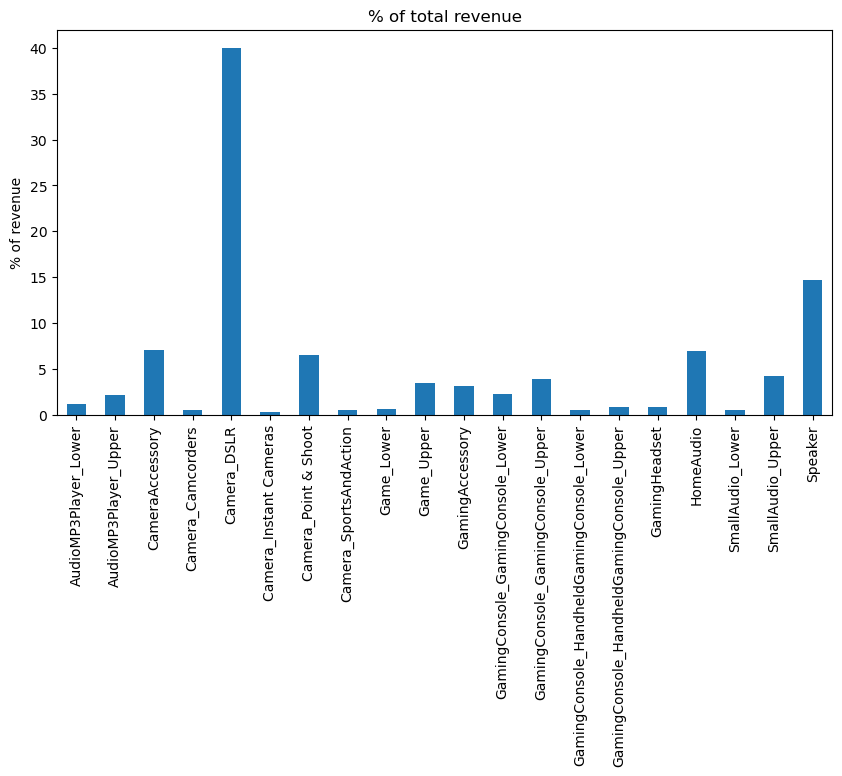

In [68]:
((marketing_data[category_columns].divide(marketing_data[category_columns].sum(axis=1),axis=0)).mean(
    
)*100).plot(kind='bar',figsize=(10,5),title='% of total revenue',ylabel="% of revenue")

In [80]:
total_columns_m = [('y_ttl',i) for i in marketing_columns]
total_columns_c = [(j,'Total.Investment') for j in category_columns]
total_columns_m.sort()
total_columns_c.sort()

Based on the plots below, there does seem to be conclusive correlation between total revenue and total marketing. Although trying to break the marketing spend into different categories causes more noise which may make it difficult to model.

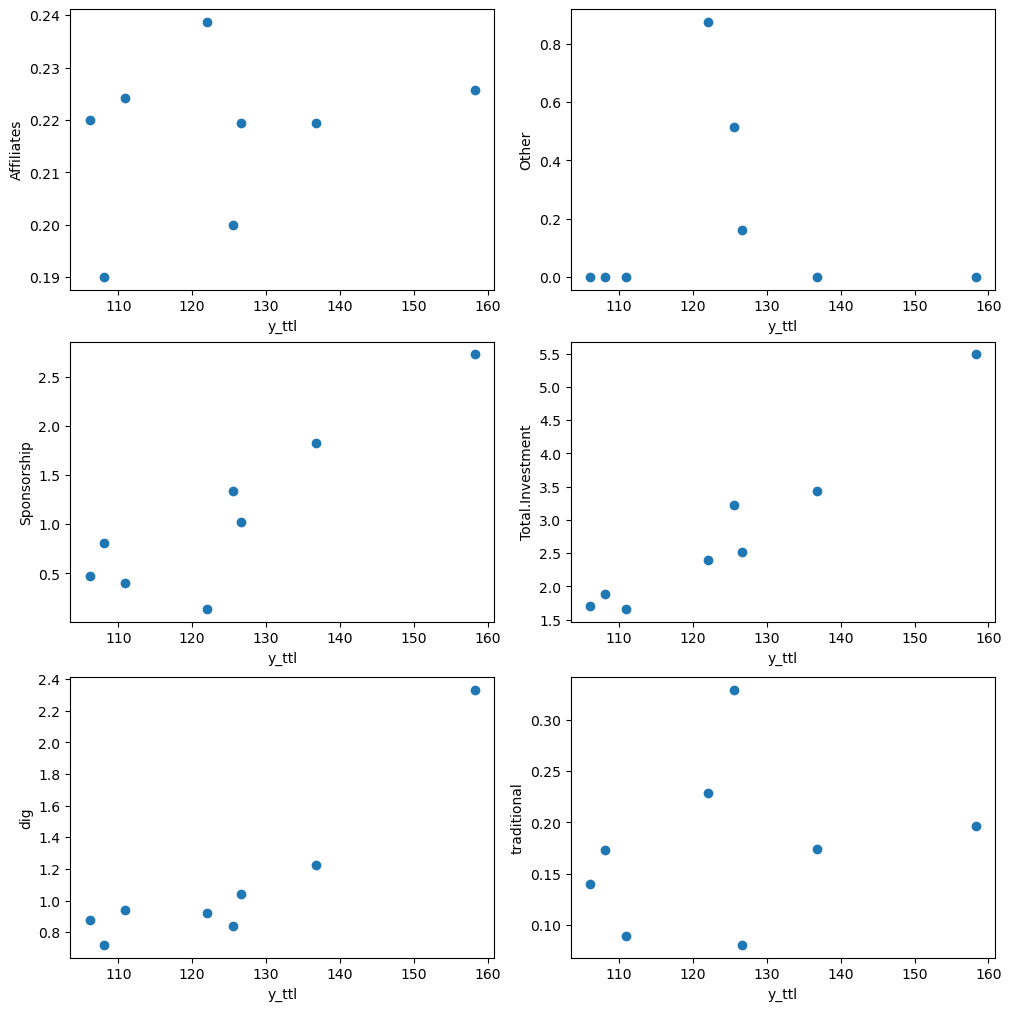

In [81]:
fig, axs = plt.subplots(3,2,figsize=(10,10),layout='constrained')

targets = zip(total_columns_m, axs.flatten())

for i, (tp,ax) in enumerate(targets):

    ax.scatter(x=marketing_data[tp[0]],y=marketing_data[tp[1]])
    ax.set_xlabel(tp[0])
    ax.set_ylabel(tp[1])

Trying to evaluate if total spending affect the total revenue in each category produces mixed results. For some, there seems to be some effect, for others not so much. We will have to go into this detail later in the causal inference section.

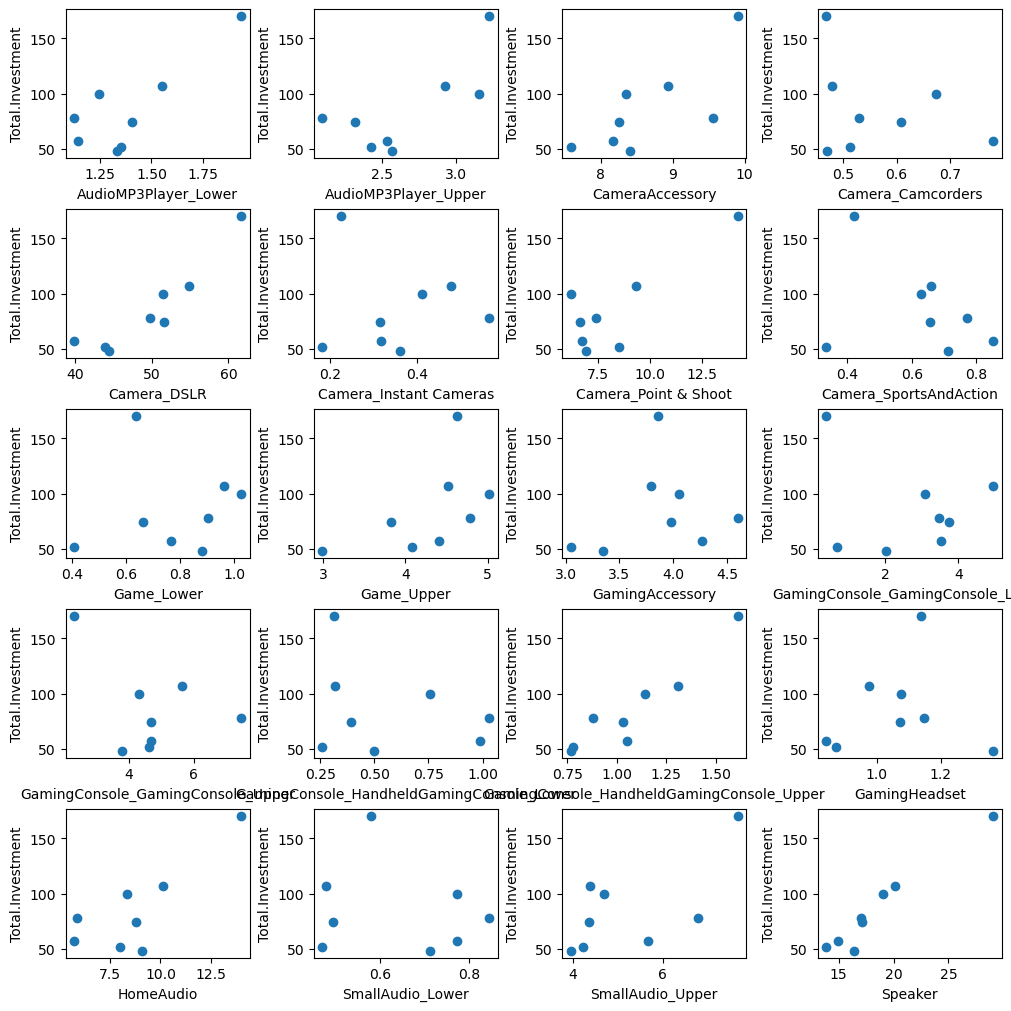

In [133]:
fig, axs = plt.subplots(5,4,figsize=(10,10),layout='constrained')

targets = zip(total_columns_c, axs.flatten())

for i, (tp,ax) in enumerate(targets):

    ax.scatter(x=marketing_data[tp[0]],y=marketing_data[tp[1]])
    ax.set_xlabel(tp[0])
    ax.set_ylabel(tp[1])

In [15]:
marketing_data['no_aff'] = marketing_data['Total.Investment'] - marketing_data['Affiliates']

Given the linearity of total spending and total marketing spend, it seems we can run a simple linear regression to model it. The model seems to have a good fit and the coefficients seem to pass the F-test that indicates robustness. 

First takeaway: Increasing total spend may cause total revenue to increase, and it has not reached the saturation point yet. We could try to increase marketing spend as a takeaway.

We, should however, be cautious, and conclude whether the effect is solely from just total investment alone or it could be due to other factors (e.g. product demand) that may play a bigger role here as this was not run as an experiment.

In [10]:
m = sm.OLS(marketing_data['y_ttl'],sm.add_constant(marketing_data['Total.Investment']))
res = m.fit()


In [11]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  y_ttl   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     100.0
Date:                Mon, 16 Sep 2024   Prob (F-statistic):           5.79e-05
Time:                        18:01:27   Log-Likelihood:                -22.140
No. Observations:                   8   AIC:                             48.28
Df Residuals:                       6   BIC:                             48.44
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               87.5075      4.000  

Text(0.5, 1.0, 'Ttl Marketing Spend vs Revenue')

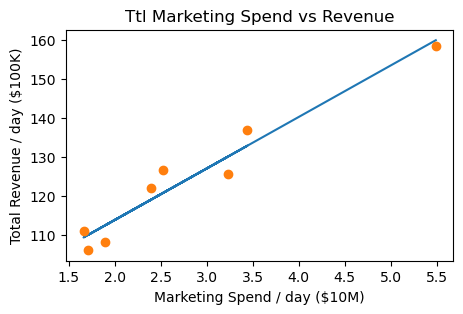

In [86]:
y_pred = 87.5075 + 13.1761 *  marketing_data['Total.Investment']

fig, ax = plt.subplots(figsize=(5,3))
ax.plot(marketing_data['Total.Investment'], y_pred, '-')
ax.plot(marketing_data['Total.Investment'], marketing_data['y_ttl'],'o')

ax.set_xlabel('Marketing Spend / day ($10M)')
ax.set_ylabel("Total Revenue / day ($100K)")
ax.set_title("Ttl Marketing Spend vs Revenue")

Note that if we try to break it down into the constituent components of spending, the model has more difficulty trying to assign correct weightage to the different spending correctly. We try to specify 3 version of linear regression 
- Model A: Fit using all except Others category, as that category has missing values and can cause high noise.
- Model B: Aggregating non affiliate and affiliate spend into two categories to gauge the effect of affiliates.
- Model C: Having no affiliate and separating it out into three groups. 

In models A and B below, we see that affiliates could play a huge portion in terms of the variance of the total revenue, although I find it difficult to believe. I think affiliates would serve as another feature to investigate for the future. There isn't a strong agreement as to which component other than affiliates that could cause more causal effects among the various three models based on models B and C.

In [12]:
model_a = sm.OLS(marketing_data['y_ttl'],sm.add_constant(marketing_data[['traditional','Affiliates','dig','Sponsorship']]))
res = model_a.fit()


In [13]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  y_ttl   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     14.69
Date:                Mon, 16 Sep 2024   Prob (F-statistic):             0.0260
Time:                        18:01:41   Log-Likelihood:                -21.528
No. Observations:                   8   AIC:                             53.06
Df Residuals:                       3   BIC:                             53.45
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -4.2529     46.737     -0.091      

In [16]:
model_b = sm.OLS(marketing_data['y_ttl'],sm.add_constant(marketing_data[['no_aff','Affiliates']]))
res = model_b.fit()


In [17]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  y_ttl   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     68.09
Date:                Mon, 16 Sep 2024   Prob (F-statistic):           0.000236
Time:                        18:02:19   Log-Likelihood:                -20.265
No. Observations:                   8   AIC:                             46.53
Df Residuals:                       5   BIC:                             46.77
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         52.1659     20.728      2.517      0.0

In [18]:
model_c = sm.OLS(marketing_data['y_ttl'],sm.add_constant(marketing_data[['traditional','dig','Sponsorship']]))
res = model_c.fit()


In [19]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  y_ttl   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     10.33
Date:                Mon, 16 Sep 2024   Prob (F-statistic):             0.0236
Time:                        18:03:01   Log-Likelihood:                -24.952
No. Observations:                   8   AIC:                             57.90
Df Residuals:                       4   BIC:                             58.22
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          88.4368     10.989      8.048      

As we look into more granular data on a local sense to determine how pricing and discounts play a role in causing behaviour changes, we'll need a model that fits everything together at the end to determine how to prioritize between the different variables.


### Determining NPS relations

This seems to be an ill posed problem. Having a simple correlation of the SLA with the NPS reveals that it is positive, which seems to indicate either something is wrong or we don't have sufficient data. We could go into further detail to try to break it down by subcategories, but given the NPS is an aggregate score that can be caused by many things including marketing spend and overall demand, I would instead focus on getting a better methodology to refine the score per product category a bit better to try to draw meaningful conclusions here.

In [142]:
marketing_data.NPS.corr(marketing_data.SLA)


0.3910024543313816

## Understanding causal structure

For the next step, we try to understand the causal structure and model the behaviour of objects of interest. Given that we expect each product category to have some variations in terms of what the functional behaviour might look like in terms of how it influences each. We encode a general structural causal model for each category that captures how each data point interacts with each and learn parameters for each model separately.

For a quick intro to the PyWhy library, see this [example](https://www.pywhy.org/dowhy/v0.11.1/example_notebooks/DoWhy-The%20Causal%20Story%20Behind%20Hotel%20Booking%20Cancellations.html) 

In [2]:
flc = pd.read_csv('../causal_inf_project/cache_flc.csv')
flc_test = pd.read_csv('../causal_inf_project/cache_flc_test.csv')

In [4]:
flc[['is_holiday','is_weekend','promos','special_dates']] = (
    flc[['is_holiday','is_weekend','promos','special_dates']].astype(int)
)
flc_test[['is_holiday','is_weekend','promos','special_dates']] = (
    flc_test[['is_holiday','is_weekend','promos','special_dates']].astype(int)
)

We set the model as follows:
- Holiday can influence promos
- Assume weekend and holidays has latent effect on overall demand to investigate. The affects both the quantity of the unit and the average unit price of the unit.
- Assume that overall product demand is captured by both unit price and units sold, but primarily by unit price. 
- Promos have an effect on discount, but does not act further on that besides shifting the overall demand, which we shift via the total unit price. Promos are mostly given by the business and are determined by independent factors.
- Total revenue is only affected by how much discount, the unit price and how much was sold in total.  
- Discounts also affect the total count of product.
- The total spending affects the total units and unit price sold

For the more granular model, we will not include total investment as it might introduce more noise than is beneficial here.

In [2]:
causal_graph = nx.DiGraph([
                          ('log_unit_mrp','units'),('log_unit_mrp','gmv_new'), ('promos','log_d'),
                        ('ttl_investment','units'),('ttl_investment','log_unit_mrp'),
                           ('log_d','units'),('log_d','gmv_new'),
                           ('is_holiday','units'),('is_holiday','log_unit_mrp'),
                           ('is_weekend','units'),('is_weekend','log_unit_mrp'),
                           ('units','gmv_new'),
                           ('promos','log_unit_mrp'),('is_holiday','promos'), 
                          ])

causal_graph_det = nx.DiGraph([
                          ('log_unit_mrp','units'),('log_unit_mrp','gmv_new'), 
                        
                           ('log_d','units'),('log_d','gmv_new'),
                           ('is_holiday','units'),
                           ('is_weekend','units'),
                           ('units','gmv_new'),
                           ('promos','units'),('is_holiday','promos'), 
                          ])

In [18]:
model = CausalModel(
   data=flc, 
   treatment="ttl_investment",
   outcome="gmv_new",
   graph="\n".join(nx.generate_gml(causal_graph))
)

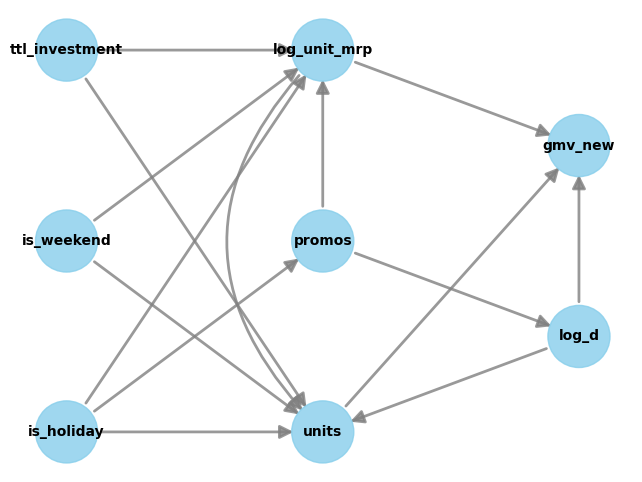

In [17]:
model.view_model()

We first try to get a sense of overall treatment effect in terms of strength, although these are not likely to be accurate, given that they will differ widely by product category and the causal model specification is relatively simple and we are not modelling product specific, but overall demand. The effect sizes here are interpreted similarly to linear regression coefficients in terms of how much 1 unit of change of input will change output. The key numbers to consider here are the mean value, rather than the conditional treatment effects, (basically, given that the other values take this range, what is the expected effect), as it does seem to indicate some nonlinear behaviour.

- We observe that ttl_investment does not seem to have a large effect given all things considered. (Is it certain this is due to random chance, or just due to too much noise from split value)
- Promos and discount have some effect on total revenue as expected. 
- Weekend does not have strong effect.
- Holidays may have some effect due to total demand. 

In [37]:
def approximate_rough_causal_effect(data,cause,endo):
    # For this exercise, we will only estimate the effect on gmv_new mostly on large scale. 
    # For holidays + promos effect. 
    model = CausalModel(
       data=data, 
       treatment=cause,
       outcome=endo,
       graph=causal_graph
    )

    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
    estimate = model.estimate_effect(identified_estimand,method_name="backdoor.linear_regression",
                                 target_units="ate")
    
    return estimate, identified_estimand, model  

In [39]:
estimate, identified_estimand, model = approximate_rough_causal_effect(flc,'ttl_investment','gmv_new')
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                    
────────────────(E[gmv_new])
d[ttlᵢₙᵥₑₛₜₘₑₙₜ]            
Estimand assumption 1, Unconfoundedness: If U→{ttl_investment} and U→gmv_new then P(gmv_new|ttl_investment,,U) = P(gmv_new|ttl_investment,)

## Realized estimand
b: gmv_new~ttl_investment+ttl_investment*is_holiday+ttl_investment*is_weekend+ttl_investment*log_d+ttl_investment*promos
Target units: 

## Estimate
Mean value: 0.015664333038138523
### Conditional Estimates
__categorical__is_holiday  __categorical__is_weekend  __categorical__log_d  __categorical__promos
(-0.001, 1.0]              (-0.001, 1.0]              (-2.217, -0.807]      (-0.001, 1.0]           -0.007665
                                                      (-0.807, -0.614]      (-0.001, 1.0]            0.010083
                                                      (-0.614, -0.47

In [40]:
## Compared to Bayesian estimate, effect may be slightly bigger than expected. 

estimate, identified_estimand, model = approximate_rough_causal_effect(flc,'is_holiday','gmv_new')
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                  
─────────────(E[gmv_new])
d[is_holiday]            
Estimand assumption 1, Unconfoundedness: If U→{is_holiday} and U→gmv_new then P(gmv_new|is_holiday,,U) = P(gmv_new|is_holiday,)

## Realized estimand
b: gmv_new~is_holiday+is_holiday*is_weekend+is_holiday*ttl_investment
Target units: 

## Estimate
Mean value: 0.22841792155610996
### Conditional Estimates
__categorical__is_weekend  __categorical__ttl_investment
(-0.001, 1.0]              (1.6580000000000001, 1.707]      0.327750
                           (1.707, 2.394]                   0.259896
                           (2.394, 2.519]                   0.278365
                           (2.519, 3.442]                   0.168544
                           (3.442, 5.49]                    0.041303
dtype: float64


In [41]:
## For the weekend estimate, if we compare to the mix model, the signs seems to be correct on average.

estimate, identified_estimand, model = approximate_rough_causal_effect(flc,'is_weekend','gmv_new')
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                  
─────────────(E[gmv_new])
d[is_weekend]            
Estimand assumption 1, Unconfoundedness: If U→{is_weekend} and U→gmv_new then P(gmv_new|is_weekend,,U) = P(gmv_new|is_weekend,)

## Realized estimand
b: gmv_new~is_weekend+is_weekend*is_holiday+is_weekend*log_d+is_weekend*promos+is_weekend*ttl_investment
Target units: 

## Estimate
Mean value: -0.046370476170961794
### Conditional Estimates
__categorical__is_holiday  __categorical__log_d  __categorical__promos  __categorical__ttl_investment
(-0.001, 1.0]              (-2.217, -0.807]      (-0.001, 1.0]          (1.6580000000000001, 1.707]     -0.150357
                                                                        (1.707, 2.394]                  -0.196787
                                                                        (2.394, 2.519]      

In [36]:
model = CausalModel(
   data=flc, 
   treatment="promos",
   outcome="gmv_new",
   graph="\n".join(nx.generate_gml(causal_graph))
)
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
estimate = model.estimate_effect(identified_estimand,method_name="backdoor.propensity_score_matching",target_units="ate")
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                           
─────────(E[gmv_new|is_holiday])
d[promos]                       
Estimand assumption 1, Unconfoundedness: If U→{promos} and U→gmv_new then P(gmv_new|promos,is_holiday,U) = P(gmv_new|promos,is_holiday)

## Realized estimand
b: gmv_new~promos+is_holiday
Target units: ate

## Estimate
Mean value: 0.9536767139484724



As this contains some significant effect, let's try to refute the estimate. 
The main concern is how much of the effect is not due to random noise, but actual promo+discount interactions. We try adding a randomly generated confounder and observe how the new effect changes. (it shouldn't if the effect was real).  

Null distribution is the distribution of effect estimates of different random causes and the p-value represents the probability of observing the new effect estimate under the new distribution.

As can see, there is probably some effect either through promos/discounts interacting together. 

In [28]:
refute1_results=model.refute_estimate(identified_estimand, estimate,
        method_name="random_common_cause")
print(refute1_results)

Refute: Add a random common cause
Estimated effect:0.9536767139484724
New effect:0.9536767139484721
p value:1.0



With a rough idea of the effects out of the way, we will proceed to do more of a detailed model of the mechanisms at play here. A few things that we will aim to predict using the more fine tuned model.

1. How do we attribute that variations in features cause variations in the total revenue.
2. How do we attribute changes in feature cause variations in the units sold. For this, we will use the more detailed model that bins the prices and discounts into 20 bins and then look at unit variation based on this. 
3. Can we explain the anomalous periods of April and October where we see a huge spike in volume?

To answer 1 + 2, after we build the model, we can run a SHAP attribution with our model to each of the features based on the end node to figure out what is a fair assignment of value to each node. This may depend on model accuracy, so in terms of model specification, we will let the module auto assign it as necessary as it should choose the regressor of best fit, except for promos, which we specify as manual logistic regression as past tests have shown a more accurate model. The tradeoff for this is that it will not allow us to run distribution changes/anomaly analysis, so another model has to be built for that.

Note: Due to some small issues with the code, the models may have to be run several times with some modifications.

In [9]:
def fit_correct_causal_mechanism(data,data1):
    scm = gcm.StructuralCausalModel(causal_graph)
    scm_det = gcm.StructuralCausalModel(causal_graph_det)
    
    gcm.auto.assign_causal_mechanisms(scm,data, override_models=True,quality=gcm.auto.AssignmentQuality.GOOD)  
    gcm.auto.assign_causal_mechanisms(scm_det,data1, override_models=True,quality=gcm.auto.AssignmentQuality.GOOD)   
    scm_det.set_causal_mechanism('promos',gcm.ClassifierFCM(classifier_model=gcm.ml.classification.create_logistic_regression_classifier(),
                                            )
                        )  
    gcm.fit(scm, data)
    gcm.fit(scm_det, data1)

    # Explore intrinsic effects first. Note, we will only do it for the granular model. The aggregate model will
    # be explored using another different model below.
    
    iccs_gran = gcm.intrinsic_causal_influence(scm_det, target_node='gmv_new', num_samples_randomization=500)
    iccs_gran_units = gcm.intrinsic_causal_influence(scm_det, target_node='units', num_samples_randomization=500)

    # Then we look at whether the weird spikes can be explained. Due to some mispecifications, we will do
    # April's section later. 

    oct_historical_changes = gcm.distribution_change(scm,
                                    data[(data.Date.isin(['2016-10-14',
                                                         '2016-10-15',
                                                          '2016-10-16',
                                                          '2016-10-17'
                                                         ])==False)],
                                    data[(data.Date.isin(['2016-10-14',
                                                         '2016-10-15',
                                                          '2016-10-16',
                                                          '2016-10-17'
                                                         ]))],
                                    target_node='units',
                                    difference_estimation_func=lambda x, y: np.mean(y) - np.mean(x))

    # Later we look at modulating discounts to see what happens here. 
    
    return {#'scm':scm,'scm_det':scm_det,
            'iccs_gran':iccs_gran,'iccs_gran_units':iccs_gran_units
        ,'oct_historical_changes':oct_historical_changes}



In [5]:
flc['promos'] = flc['promos'].astype('str')
flc_test['promos'] = flc_test['promos'].astype('str')

In [7]:
name_dict={}
 
for name, group in flc.groupby('new_cat'):
    name_dict.update({name: fit_correct_causal_mechanism(group,
                                     flc_test[(flc_test.new_cat==name)]
                                     )
                     }
                    )

Fitting causal mechanism of node promos: 100%|███████████████████████████████████████████| 7/7 [00:01<00:00,  3.70it/s]
Estimating Shapley Values. Average change of Shapley values in run 13 (65 evaluated permutations): 0.967435757281083%: 
Estimating Shapley Values. Average change of Shapley values in run 12 (60 evaluated permutations): 1.4189939257312358%:
Estimating Shapley Values. Average change of Shapley values in run 35 (175 evaluated permutations): 0.2146076669016478%
Estimating Shapley Values. Average change of Shapley values in run 31 (155 evaluated permutations): 1.3461592902544284%
Estimating Shapley Values. Average change of Shapley values in run 114 (570 evaluated permutations): 1.6071051589504042
Fitting causal mechanism of node promos: 100%|███████████████████████████████████████████| 7/7 [00:00<00:00,  8.61it/s]
Estimating Shapley Values. Average change of Shapley values in run 15 (75 evaluated permutations): 1.0252768372529832%:
Estimating Shapley Values. Average chang

UnboundLocalError: cannot access local variable 'april_anomaly' where it is not associated with a value

In [11]:
# Retry of above attempt

for name, group in flc.groupby('new_cat'):
    if name not in ('AudioMP3Player_Lower', 'AudioMP3Player_Upper', 'CameraAccessory'):    
        name_dict.update({name: fit_correct_causal_mechanism(group,
                                         flc_test[(flc_test.new_cat==name)]
                                         )
                         }
                        )
    else:
        continue

Fitting causal mechanism of node promos: 100%|██████████████████████████████████████████| 7/7 [00:00<00:00, 158.95it/s]
Estimating Shapley Values. Average change of Shapley values in run 21 (105 evaluated permutations): 0.6158770659833247%
Estimating Shapley Values. Average change of Shapley values in run 15 (75 evaluated permutations): 2.2479955112028365%:
Estimating Shapley Values. Average change of Shapley values in run 22 (110 evaluated permutations): 1.054088346665663%:
Estimating Shapley Values. Average change of Shapley values in run 373 (1865 evaluated permutations): 1.832218119456543
Fitting causal mechanism of node promos: 100%|███████████████████████████████████████████| 7/7 [00:01<00:00,  4.30it/s]
Estimating Shapley Values. Average change of Shapley values in run 13 (65 evaluated permutations): 0.9938510957042392%:
Estimating Shapley Values. Average change of Shapley values in run 9 (45 evaluated permutations): 1.0966511617698829%: 
Estimating Shapley Values. Average chang

IndexError: index 0 is out of bounds for axis 0 with size 0

In [24]:
# Retry of above attempt

for name, group in flc.groupby('new_cat'):
    if name not in name_dict.keys() and name!='GamingConsole_HandheldGamingConsole_Lower' and name!='GamingConsole_HandheldGamingConsole_Upper':    
        name_dict.update({name: fit_correct_causal_mechanism(group,
                                         flc_test[(flc_test.new_cat==name)]
                                         )
                         }
                        )
    else:
        continue

Fitting causal mechanism of node promos: 100%|███████████████████████████████████████████| 7/7 [00:01<00:00,  6.38it/s]
Estimating Shapley Values. Average change of Shapley values in run 14 (70 evaluated permutations): 1.6632171707205292%:
Estimating Shapley Values. Average change of Shapley values in run 13 (65 evaluated permutations): 1.6344924525225475%:
Estimating Shapley Values. Average change of Shapley values in run 80 (400 evaluated permutations): 0.36267830318898325
Estimating Shapley Values. Average change of Shapley values in run 22 (110 evaluated permutations): 1.4437533683182968%
Estimating Shapley Values. Average change of Shapley values in run 47 (235 evaluated permutations): 2.2210816317856454%
Fitting causal mechanism of node promos: 100%|███████████████████████████████████████████| 7/7 [00:01<00:00,  6.20it/s]
Estimating Shapley Values. Average change of Shapley values in run 16 (80 evaluated permutations): 0.6950586275403617%:
Estimating Shapley Values. Average chang

One can verify by running the code above, but should get the data below. We store it as a string as there were issues working with processing some of the data.

In [2]:
mem_str = """
    {'AudioMP3Player_Lower': {'iccs_gran': {'log_unit_mrp': 0.46756631655291014,
   'log_d': 0.1735638940002804,
   'is_holiday': 0.0006657096965189023,
   'is_weekend': 0.0009160480178003051,
   'promos': 0.007193602116335497,
   'units': 0.5312790528584568,
   'gmv_new': 0.005919116511840353},
  'iccs_gran_units': {'log_unit_mrp': 31.723416930515153,
   'log_d': 11.886133588481442,
   'is_holiday': 0.032262451997098304,
   'is_weekend': -0.32323736980152934,
   'promos': 1.7182476552623307,
   'units': 306.2043245139649},
  'oct_historical_changes': {'is_holiday': 0.002504331919703321,
   'is_weekend': 0.0019097543797435752,
   'log_d': 0.0004452260481061075,
   'log_unit_mrp': -0.0024865917174083435,
   'promos': 0.0038605738579565265,
   'ttl_investment': 0.0005735976573014532,
   'units': -0.004305804303349366}},
 'AudioMP3Player_Upper': {'iccs_gran': {'log_unit_mrp': 0.5067211661809826,
   'log_d': 0.25162915540160896,
   'is_holiday': 0.0002568877469918309,
   'is_weekend': 0.0014733356364864947,
   'promos': 0.0019343051395164974,
   'units': 0.2068195138744736,
   'gmv_new': 0.0034676034339201924},
  'iccs_gran_units': {'log_unit_mrp': 5.315637357219995,
   'log_d': 1.6637147707279394,
   'is_holiday': 0.013468323290793685,
   'is_weekend': 0.20127613095139515,
   'promos': 0.009499491147088122,
   'units': 22.340385611325715},
  'oct_historical_changes': {'is_holiday': -0.0069727423800471176,
   'is_weekend': -0.0077899791754342225,
   'log_d': -0.0015131317708221377,
   'log_unit_mrp': 0.002050423312695814,
   'promos': -0.005969717920812607,
   'ttl_investment': -0.006750537868555361,
   'units': -0.004498851595861381}},
 'CameraAccessory': {'iccs_gran': {'log_unit_mrp': 0.7049083761825718,
   'log_d': 0.4292982711882561,
   'is_holiday': 0.00024031716832430264,
   'is_weekend': 0.002620508415676952,
   'promos': 0.009493015358438595,
   'units': 0.49143201477467846,
   'gmv_new': 0.009308782290526266},
  'iccs_gran_units': {'log_unit_mrp': 41.7360888754369,
   'log_d': 12.16900553910109,
   'is_holiday': -0.5270831681094369,
   'is_weekend': 1.3529467047854633,
   'promos': 4.1618133613847235,
   'units': 333.54889086240706},
  'oct_historical_changes': {'is_holiday': -0.002381858120449371,
   'is_weekend': -0.0007944813036947718,
   'log_d': -0.0013311936004044757,
   'log_unit_mrp': 0.004229872722490193,
   'promos': 0.0013436750338131583,
   'ttl_investment': -0.002449871282277172,
   'units': -0.0008978632754639107}},
 'Camera_Camcorders': {'iccs_gran': {'log_unit_mrp': 0.44470777944980283,
   'log_d': 0.06088913049358367,
   'is_holiday': 0.00018794563590110935,
   'is_weekend': 0.0021746179864389425,
   'promos': 0.0014662129859181797,
   'units': 0.5132637793580022,
   'gmv_new': 0.005155645304283787},
  'iccs_gran_units': {'log_unit_mrp': 0.018054572914431563,
   'log_d': 0.013071919651565388,
   'is_holiday': 0.0008645425626326754,
   'is_weekend': 0.0036547864892818604,
   'promos': 0.001936117644313738,
   'units': 0.6249936112332394},
  'oct_historical_changes': {'is_holiday': 0.004293171131983918,
   'is_weekend': 0.0022954055491032107,
   'log_d': -0.00026072317015160063,
   'log_unit_mrp': 0.003947700823124807,
   'promos': -0.0017912328788770057,
   'ttl_investment': 0.007382900872242343,
   'units': 0.004998523587912843}},
 'Camera_DSLR': {'iccs_gran': {'log_unit_mrp': 1.211017740702706,
   'log_d': 0.27342979816213187,
   'is_holiday': 0.022302277547964145,
   'is_weekend': 0.034880851688544386,
   'promos': 0.04500601326756095,
   'units': 0.8960768471531267,
   'gmv_new': 0.007676260095123609},
  'iccs_gran_units': {'log_unit_mrp': 114.0082142964535,
   'log_d': 155.009093895368,
   'is_holiday': 2.7920575621839183,
   'is_weekend': 11.169587569359372,
   'promos': 35.523336984176765,
   'units': 968.9941937449119},
  'oct_historical_changes': {'is_holiday': 0.002359810248955664,
   'is_weekend': 0.003791710599722665,
   'log_d': -0.004289319287944448,
   'log_unit_mrp': 0.004503030912708638,
   'promos': 0.0027119252825728215,
   'ttl_investment': -0.003875187462219077,
   'units': -0.002302346939618004}},
 'Camera_Instant Cameras': {'iccs_gran': {'log_unit_mrp': 0.019170633587000503,
   'log_d': 0.07758556739199496,
   'is_holiday': -6.078604706913903e-05,
   'is_weekend': 0.0012678737016964825,
   'promos': 0.0009540901581116595,
   'units': 0.30747630685574745,
   'gmv_new': 0.11705478886275067},
  'iccs_gran_units': {'log_unit_mrp': 0.984805970517472,
   'log_d': 0.7879675663486596,
   'is_holiday': -0.0034069206035996186,
   'is_weekend': 0.03637515649398581,
   'promos': 0.03736749803501868,
   'units': 5.883886761706708},
  'oct_historical_changes': {'is_holiday': 0.001097538337722681,
   'is_weekend': -0.0011891351532170985,
   'log_d': -0.00640249001983502,
   'log_unit_mrp': 0.0002866933502569093,
   'promos': -0.007147163219642036,
   'ttl_investment': -0.00164956349337228,
   'units': 0.0007779526486286915}},
 'Camera_Point & Shoot': {'iccs_gran': {'log_unit_mrp': 0.25776512867317625,
   'log_d': 0.19464786581671395,
   'is_holiday': 0.0007558056081079204,
   'is_weekend': 0.0048870619526013015,
   'promos': 0.03798954890597357,
   'units': 0.36266774394076456,
   'gmv_new': 0.008785486721052465},
  'iccs_gran_units': {'log_unit_mrp': 1.9730898644703452,
   'log_d': 0.024504945312438697,
   'is_holiday': 0.02844459972198825,
   'is_weekend': 0.24110609876134204,
   'promos': 0.4036234156981008,
   'units': 45.14651264700738},
  'oct_historical_changes': {'is_holiday': 0.0044771382368261085,
   'is_weekend': 0.00481285443874917,
   'log_d': 0.0020113058975203928,
   'log_unit_mrp': 0.0033171699001980515,
   'promos': 0.0035919106076888903,
   'ttl_investment': 0.00030244674788907857,
   'units': 0.0007431707295483387}},
 'Camera_SportsAndAction': {'iccs_gran': {'log_unit_mrp': 0.6705326678266278,
   'log_d': 0.04773024558228735,
   'is_holiday': 0.0001377387849707522,
   'is_weekend': 0.0023154265474312173,
   'promos': 0.0005603037567173251,
   'units': 0.11656461926951024,
   'gmv_new': 0.0032059855224385557},
  'iccs_gran_units': {'log_unit_mrp': 0.802879413375774,
   'log_d': 0.899721708129025,
   'is_holiday': -0.0008321230041254992,
   'is_weekend': 0.00553037236576243,
   'promos': 0.025315164916653452,
   'units': 3.403774591481971},
  'oct_historical_changes': {'is_holiday': 0.0030496382703408594,
   'is_weekend': -0.0003306649971922284,
   'log_d': -0.007270957689093461,
   'log_unit_mrp': -0.004171746857739773,
   'promos': 0.0027188940772305305,
   'ttl_investment': -0.003867536511441406,
   'units': 0.000983937960045646}},
 'Game_Lower': {'iccs_gran': {'log_unit_mrp': 0.6994242631724948,
   'log_d': 0.4478606553798161,
   'is_holiday': -0.00013897651201513287,
   'is_weekend': 0.001717922649049289,
   'promos': 0.010168302646157423,
   'units': 0.30550138106011293,
   'gmv_new': 0.009795954766029015},
  'iccs_gran_units': {'log_unit_mrp': 2.4901941705296537,
   'log_d': 1.7306723079554054,
   'is_holiday': 0.037912209088084674,
   'is_weekend': 0.12173701662365247,
   'promos': 0.47452810534594314,
   'units': 16.2004285384854},
  'oct_historical_changes': {'is_holiday': -0.0009236773860878028,
   'is_weekend': -0.002687926324124513,
   'log_d': -0.004923562603812119,
   'log_unit_mrp': 0.0009373176576632483,
   'promos': 0.0016250009300854454,
   'ttl_investment': 0.004258090143301313,
   'units': -0.0026862065923779787}},
 'Game_Upper': {'iccs_gran': {'log_unit_mrp': 0.18745405638698032,
   'log_d': 0.4428284255350216,
   'is_holiday': 0.0019115035193095953,
   'is_weekend': 0.0037756170026682708,
   'promos': 0.021105600738078614,
   'units': 0.42547469943323435,
   'gmv_new': 0.004164183279655526},
  'iccs_gran_units': {'log_unit_mrp': 3.797336344331664,
   'log_d': 5.143702588307702,
   'is_holiday': 0.02908669018993308,
   'is_weekend': 0.24481149643517305,
   'promos': -0.6498089436625016,
   'units': 65.39289354234643},
  'oct_historical_changes': {'is_holiday': -0.001400769584982162,
   'is_weekend': -0.004593015735942954,
   'log_d': -0.007586449648651867,
   'log_unit_mrp': -0.0023542042344718204,
   'promos': -0.00572037420755306,
   'ttl_investment': -0.005878818690815666,
   'units': 0.002310153587632848}},
 'GamingAccessory': {'iccs_gran': {'log_unit_mrp': 0.7715164911192248,
   'log_d': 0.24142144869451448,
   'is_holiday': 0.0011600108119861241,
   'is_weekend': 0.0027508792599797247,
   'promos': 0.012422792468801612,
   'units': 0.4478832650505276,
   'gmv_new': 0.016001637646344578},
  'iccs_gran_units': {'log_unit_mrp': 1.7032785004661826,
   'log_d': 0.18271768351585777,
   'is_holiday': 0.0014124345316590585,
   'is_weekend': 0.17185141863542455,
   'promos': 0.3481260548436271,
   'units': 100.43417392699504},
  'oct_historical_changes': {'is_holiday': -0.001416789048635921,
   'is_weekend': -0.002399304859085486,
   'log_d': -0.002504660251447682,
   'log_unit_mrp': -0.00023554219756216974,
   'promos': 0.0008994077476744931,
   'ttl_investment': -0.001430781266864413,
   'units': -0.001402667061693628}},
 'GamingConsole_GamingConsole_Lower': {'iccs_gran': {'log_unit_mrp': 0.18413766026273223,
   'log_d': 0.1523378180543551,
   'is_holiday': 0.005535431913881492,
   'is_weekend': 0.01619683753384498,
   'promos': 0.009023778147994259,
   'units': 0.28810549741247915,
   'gmv_new': 0.004557867291047772},
  'iccs_gran_units': {'log_unit_mrp': 1.4053518680843005,
   'log_d': 4.272833035118289,
   'is_holiday': 0.03783204304932706,
   'is_weekend': 0.38005410588555205,
   'promos': 0.29360134066422544,
   'units': 22.06095508897477},
  'oct_historical_changes': {'is_holiday': -0.004753141138245144,
   'is_weekend': 0.00857056985059089,
   'log_d': 0.0011752328429182539,
   'log_unit_mrp': 0.004952916589822305,
   'promos': -0.0008947278777096451,
   'ttl_investment': -0.012501022361684664,
   'units': 0.004469322173708796}},
 'GamingConsole_GamingConsole_Upper': {'iccs_gran': {'log_unit_mrp': 0.0558867388396587,
   'log_d': 0.11877181539739687,
   'is_holiday': -0.00014469354481128665,
   'is_weekend': 0.0031978545103326004,
   'promos': 0.021336511805352235,
   'units': 0.2827113187219177,
   'gmv_new': 0.002164355198637441},
  'iccs_gran_units': {'log_unit_mrp': 0.7483210961298998,
   'log_d': 2.8637961287159195,
   'is_holiday': 0.008783938215586016,
   'is_weekend': 0.05366266028294397,
   'promos': 0.5567407569385329,
   'units': 9.928627412403138},
  'oct_historical_changes': {'is_holiday': -0.0037343960246417176,
   'is_weekend': -0.00027939514761165797,
   'log_d': 0.005057512709391748,
   'log_unit_mrp': 0.00022676946276773018,
   'promos': 0.005087439065613374,
   'ttl_investment': 0.0035346029116086895,
   'units': -0.0021580979013650662}},
 'GamingHeadset': {'iccs_gran': {'log_unit_mrp': 0.5796589585265995,
   'log_d': 0.18186223407510768,
   'is_holiday': 0.0003736908006832766,
   'is_weekend': 0.0014892782473152535,
   'promos': 0.011284763271182125,
   'units': 0.4839640857102843,
   'gmv_new': 0.009938964179082814},
  'iccs_gran_units': {'log_unit_mrp': 19.0005968951059,
   'log_d': 26.5937330888386,
   'is_holiday': -0.01709184319913789,
   'is_weekend': 0.5942948479545047,
   'promos': 4.262242550698319,
   'units': 138.796500146934},
  'oct_historical_changes': {'is_holiday': 0.0047321739139325305,
   'is_weekend': 0.0031256380360187796,
   'log_d': -0.0023704865746261945,
   'log_unit_mrp': 0.004074517597346616,
   'promos': 0.0017155774674294506,
   'ttl_investment': 0.010722148394578957,
   'units': 0.008068700012435969}},
 'HomeAudio': {'iccs_gran': {'log_unit_mrp': 1.0744200530645962,
   'log_d': 0.2526569385099343,
   'is_holiday': 0.0002353860384838155,
   'is_weekend': 0.0004966231938580287,
   'promos': 0.011007147633582327,
   'units': 0.5036051405931461,
   'gmv_new': 0.008977112242161215},
  'iccs_gran_units': {'log_unit_mrp': 12.172161234760281,
   'log_d': 9.936970202110736,
   'is_holiday': 0.05264172128063417,
   'is_weekend': -0.48628875381398773,
   'promos': 2.931497091512693,
   'units': 63.28778272314607},
  'oct_historical_changes': {'is_holiday': 0.0063200595918411,
   'is_weekend': 0.005840054460256171,
   'log_d': -0.0045733663978412015,
   'log_unit_mrp': -0.000915555205687606,
   'promos': 0.015507257095750487,
   'ttl_investment': 0.005253575395927583,
   'units': 0.01214118960644929}},
 'SmallAudio_Lower': {'iccs_gran': {'log_unit_mrp': 0.2807582999489172,
   'log_d': 0.08924406423136484,
   'is_holiday': -2.9168189022989033e-05,
   'is_weekend': -9.926247804286244e-05,
   'promos': 0.0003442785046685171,
   'units': 0.3293298390755846,
   'gmv_new': 0.013785660975050988},
  'iccs_gran_units': {'log_unit_mrp': 5.874835950981686,
   'log_d': 3.662763386659041,
   'is_holiday': 0.02606014937543718,
   'is_weekend': 0.033820229067100874,
   'promos': -0.056870563992316374,
   'units': 28.35367190195702},
  'oct_historical_changes': {'is_holiday': 0.0004994885173762802,
   'is_weekend': -0.0006256291785635281,
   'log_d': 0.0010526704586150649,
   'log_unit_mrp': -0.0011306731217180447,
   'promos': 0.0023234535875983754,
   'ttl_investment': 0.0016566771174260325,
   'units': 0.0033473688538321}},
 'SmallAudio_Upper': {'iccs_gran': {'log_unit_mrp': 0.45559821221157887,
   'log_d': 0.49607289232090324,
   'is_holiday': 0.0029923781685512185,
   'is_weekend': 0.023573125814228154,
   'promos': 0.021734504196348658,
   'units': 0.5508267604602908,
   'gmv_new': 0.0061264603463578055},
  'iccs_gran_units': {'log_unit_mrp': 3.7461462927653923,
   'log_d': 0.4592433935155075,
   'is_holiday': 0.06530652563113462,
   'is_weekend': 1.1123288602290318,
   'promos': 2.756639345158687,
   'units': 177.11164882376548},
  'oct_historical_changes': {'is_holiday': 0.0029145618043985486,
   'is_weekend': 6.63931729952728e-05,
   'log_d': 0.0003607552455826618,
   'log_unit_mrp': 0.0015358010978917768,
   'promos': 0.0008858019854442164,
   'ttl_investment': -0.00023914078480753416,
   'units': 0.004429788548772075}},
 'Speaker': {'iccs_gran': {'log_unit_mrp': 0.6711501159557424,
   'log_d': 0.6431290351731149,
   'is_holiday': 0.005707661508118492,
   'is_weekend': 0.011427505021169264,
   'promos': 0.03869888834001862,
   'units': 0.9878647553212798,
   'gmv_new': 0.005422166568366561},
  'iccs_gran_units': {'log_unit_mrp': 171.2438526799364,
   'log_d': 22.387380480780497,
   'is_holiday': 1.0263477713540454,
   'is_weekend': 0.7363697021067422,
   'promos': 33.47401042358946,
   'units': 5222.676811760988},
  'oct_historical_changes': {'is_holiday': 0.002722894633569553,
   'is_weekend': 0.004510090510311998,
   'log_d': 0.0042741856187929,
   'log_unit_mrp': 0.002004903146201006,
   'promos': 0.008478109299397319,
   'ttl_investment': 0.0003122760319238332,
   'units': 0.0031519976211608902}}}
   """
 

In [2]:
import ast

In [4]:
mem_str = mem_str.replace('array([','').replace('])','').replace(' ','').replace('\n','')
name_dict = ast.literal_eval(mem_str)

We now create the model to do GMV attribution on aggregate. The difference between this model and the previous was that this specified the logistic regression so that promos would fit more accurately, and hence provide a better reflection of the importance value in the SHAP analysis for the aggregate model rather than just the one focused on the granular level.

In [43]:
# Respecify only for aggregate effect model as it can't do anomaly attribution.

icc_agg_dict={}
 
for name, group in flc.groupby('new_cat'):
    scm = gcm.StructuralCausalModel(causal_graph)
        
    gcm.auto.assign_causal_mechanisms(scm,group, override_models=True,quality=gcm.auto.AssignmentQuality.GOOD)  
    scm.set_causal_mechanism('promos',gcm.ClassifierFCM(classifier_model=gcm.ml.classification.create_logistic_regression_classifier(),
                                                )
                            )  
    gcm.fit(scm, group)
    
        # Explore intrinsic effects first.
    
    iccs = gcm.intrinsic_causal_influence(scm, target_node='gmv_new', num_samples_randomization=500)
    icc_agg_dict.update({name: iccs
                     }
                    )

Fitting causal mechanism of node is_weekend: 100%|███████████████████████████████████████| 8/8 [00:00<00:00, 31.99it/s]
Estimating Shapley Values. Average change of Shapley values in run 10 (50 evaluated permutations): 0.7262400688088546%:
Fitting causal mechanism of node is_weekend: 100%|███████████████████████████████████████| 8/8 [00:00<00:00, 37.76it/s]
Estimating Shapley Values. Average change of Shapley values in run 13 (65 evaluated permutations): 0.7097586807650282%:
Fitting causal mechanism of node is_weekend: 100%|███████████████████████████████████████| 8/8 [00:00<00:00, 35.76it/s]
Estimating Shapley Values. Average change of Shapley values in run 11 (55 evaluated permutations): 0.5779350718701781%:
Fitting causal mechanism of node is_weekend: 100%|███████████████████████████████████████| 8/8 [00:00<00:00, 29.88it/s]
Estimating Shapley Values. Average change of Shapley values in run 56 (280 evaluated permutations): 0.539104882371104%:
Fitting causal mechanism of node is_week

In [44]:
icc_agg_dict

{'AudioMP3Player_Lower': {'ttl_investment': 0.019016576031042662,
  'is_holiday': 9.435837355629352e-05,
  'is_weekend': 0.0006869899681964157,
  'promos': 4.140816925189252e-05,
  'log_d': 0.0021002525077491157,
  'log_unit_mrp': 0.0036852661970167865,
  'units': 0.16561486649655788,
  'gmv_new': 0.0012828972652731308},
 'AudioMP3Player_Upper': {'ttl_investment': 0.016738511164545795,
  'is_holiday': 0.004430168873937559,
  'is_weekend': 0.008327152000068002,
  'promos': 0.00044760470103550416,
  'log_d': 0.27201343806183625,
  'log_unit_mrp': 0.009955449939623544,
  'units': 0.1560873541638161,
  'gmv_new': 0.0030870675177629933},
 'CameraAccessory': {'ttl_investment': 0.030841996505501897,
  'is_holiday': 0.00481377543781893,
  'is_weekend': 0.010266592952540971,
  'promos': 0.001087177174278708,
  'log_d': 0.01092681220711048,
  'log_unit_mrp': 0.006189894625684266,
  'units': 0.1642574230170381,
  'gmv_new': 0.009446688851684764},
 'Camera_Camcorders': {'ttl_investment': 0.0401987

In [69]:
ics_units = {key: name_dict.get(key)['iccs_gran_units'] for key in name_dict.keys()} 
ics_gran = {key: name_dict.get(key)['iccs_gran'] for key in name_dict.keys()} 
oct_anom = {key: name_dict.get(key)['oct_historical_changes'] for key in name_dict.keys()}


### Understanding the results

Let's validate for the model that it's a decent fit and that we have a good explaination of the data. We take it for the main contributors of the revenue, which is Camera DSLR. 

Test permutations of given graph: 100%|████████████████████████████████████████████████| 50/50 [00:21<00:00,  2.34it/s]


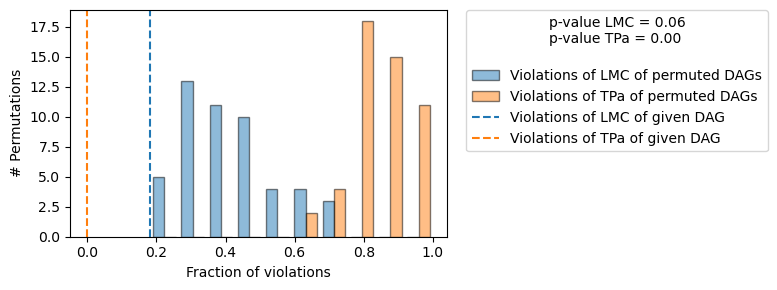

Evaluated the performance of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the underlying classifier model.
- (normalized) Continuous Ranked P

In [58]:
scm = gcm.StructuralCausalModel(causal_graph)
    
gcm.auto.assign_causal_mechanisms(scm,flc[flc.new_cat=='Camera_DSLR'], override_models=True,quality=gcm.auto.AssignmentQuality.GOOD)  
scm.set_causal_mechanism('promos',gcm.ClassifierFCM(classifier_model=gcm.ml.classification.create_logistic_regression_classifier(),
                                            )
                        )  
gcm.fit(scm, flc[flc.new_cat=='Camera_DSLR'])

print(gcm.evaluate_causal_model(scm, flc[flc.new_cat=='Camera_DSLR'], compare_mechanism_baselines=True, 
                            evaluate_invertibility_assumptions=False))

The above seems to indicate that the fit is decent, although more improvement can be done here. In terms of the LMC and Markov conditions, these inform whether or not we've specified the correct causal structure or not (this indicates that at the very least, the structure is enough to draw meaningful inferences) even if there are a few errors of the models. See [here](https://www.pywhy.org/dowhy/v0.11.1/example_notebooks/gcm_falsify_dag.html)

Given this is the case, we start plotting our results and begin our analysis.

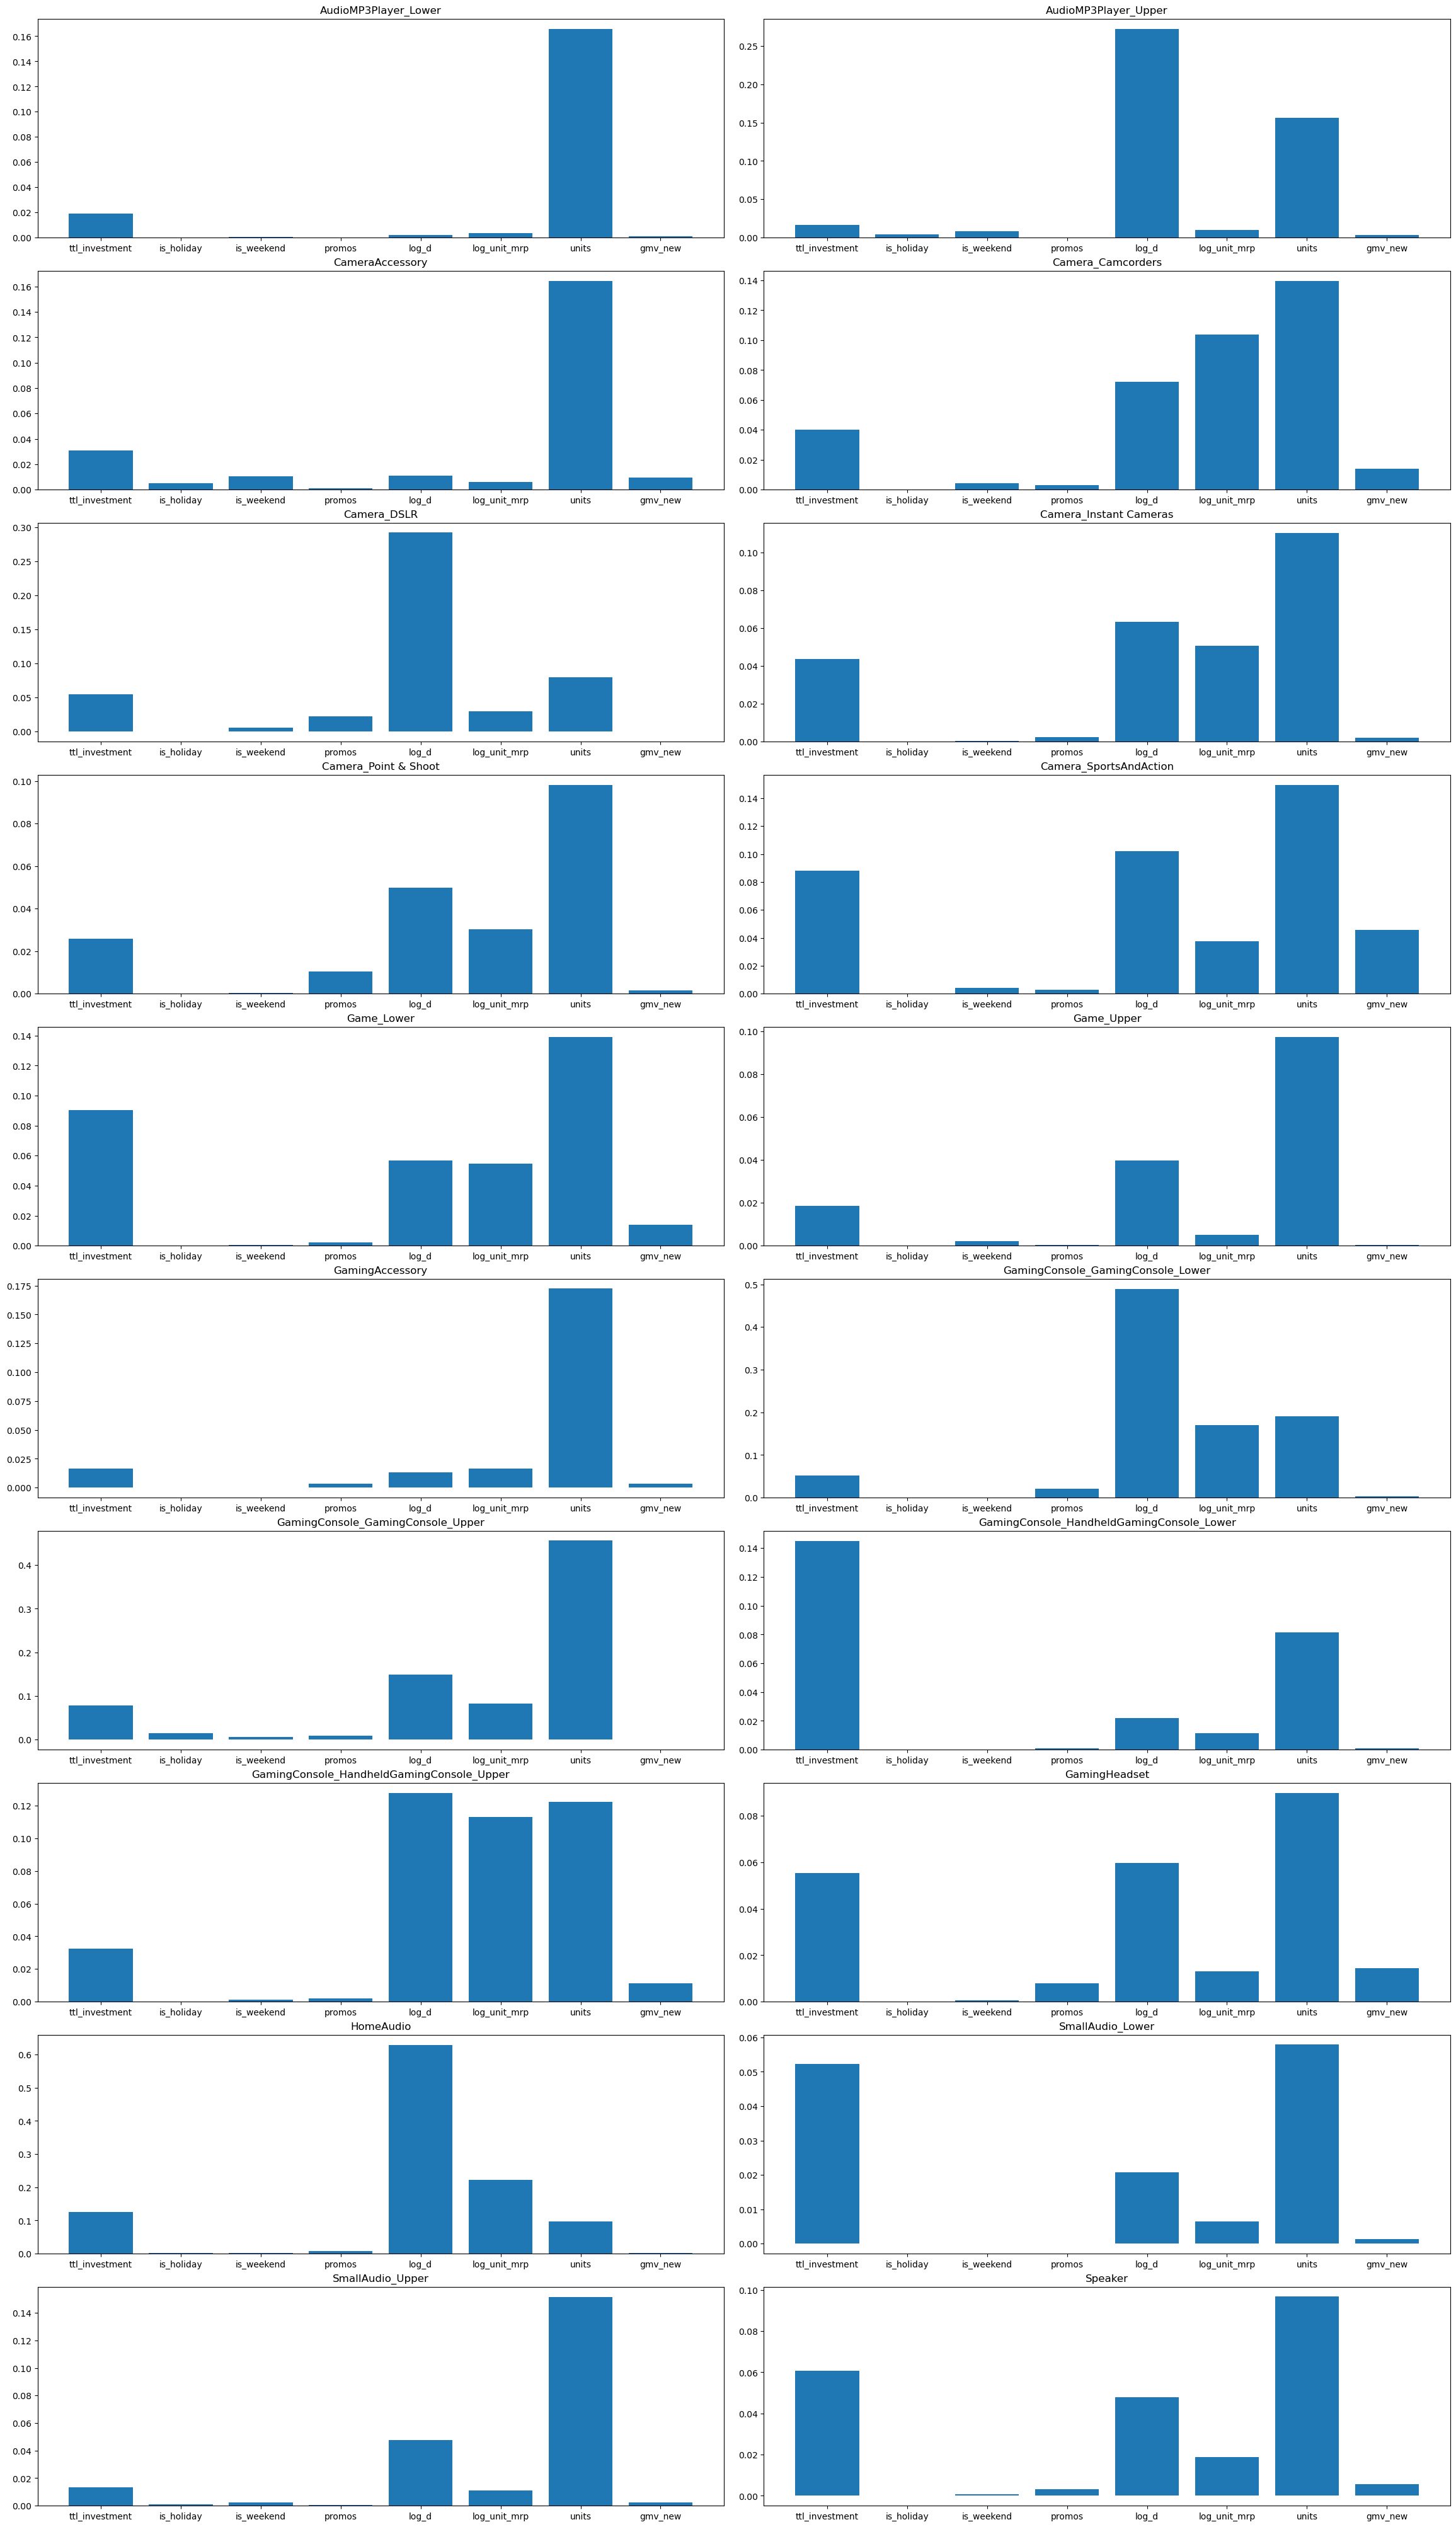

In [48]:
# Plot the charts of the aggregate SHAP attribution

fig, axs = plt.subplots(10,2,figsize=(23,40),layout='constrained')

targets = zip(icc_agg_dict.keys(), axs.flatten())
columns = list(icc_agg_dict['HomeAudio'].keys())

for i, (name,ax) in enumerate(targets):
    ax.set_title(name)
    ax.bar(x=columns,height=icc_agg_dict[name].values())
    ax.set_ylabel('')

The SHAP values here are an arbitrary measure that will have different calibration depending on each product (i.e. DO NOT compare the units cross diagrams, they only make sense comparing within each diagram). The idea is similar to using SHAP to explain machine learning where it weighs the contribution of each cause in some sense as it varies.  

From the above:

1. Ttl_investment may have a big effect, but I would be cautious given the Bayesian model does not agree.
I've also spread it out in various dimensions, but this seems to indicate that there may be some stronger effect that was previously not noted and that it is worth investing some time in the next section.

2. We see that the effect of promos is mostly through discounts that are affecting it. Promos itself don't play too much of a role, although there is some effect by the audience knowing about it. It seems similar to weekend/holiday effects in terms of its actual impact, which is also what we observe in the Bayesian mixed model.
3. Log_d (discounts) is the biggest part to consider here. It overwhelmingly, has a large impact, which is verified with our other model. This should be the focus area for development in the future.
4. Although pricing can play a role in some cases, it's not large. Overall units (product demand) still plays a huge role, which we need more user features to understand what causes attraction here. 

When we look at the granular chart (below), we can also check what affects units. We see although pricing and discount may play some, there is still some unexplained demand overall causing units to have change considerably.

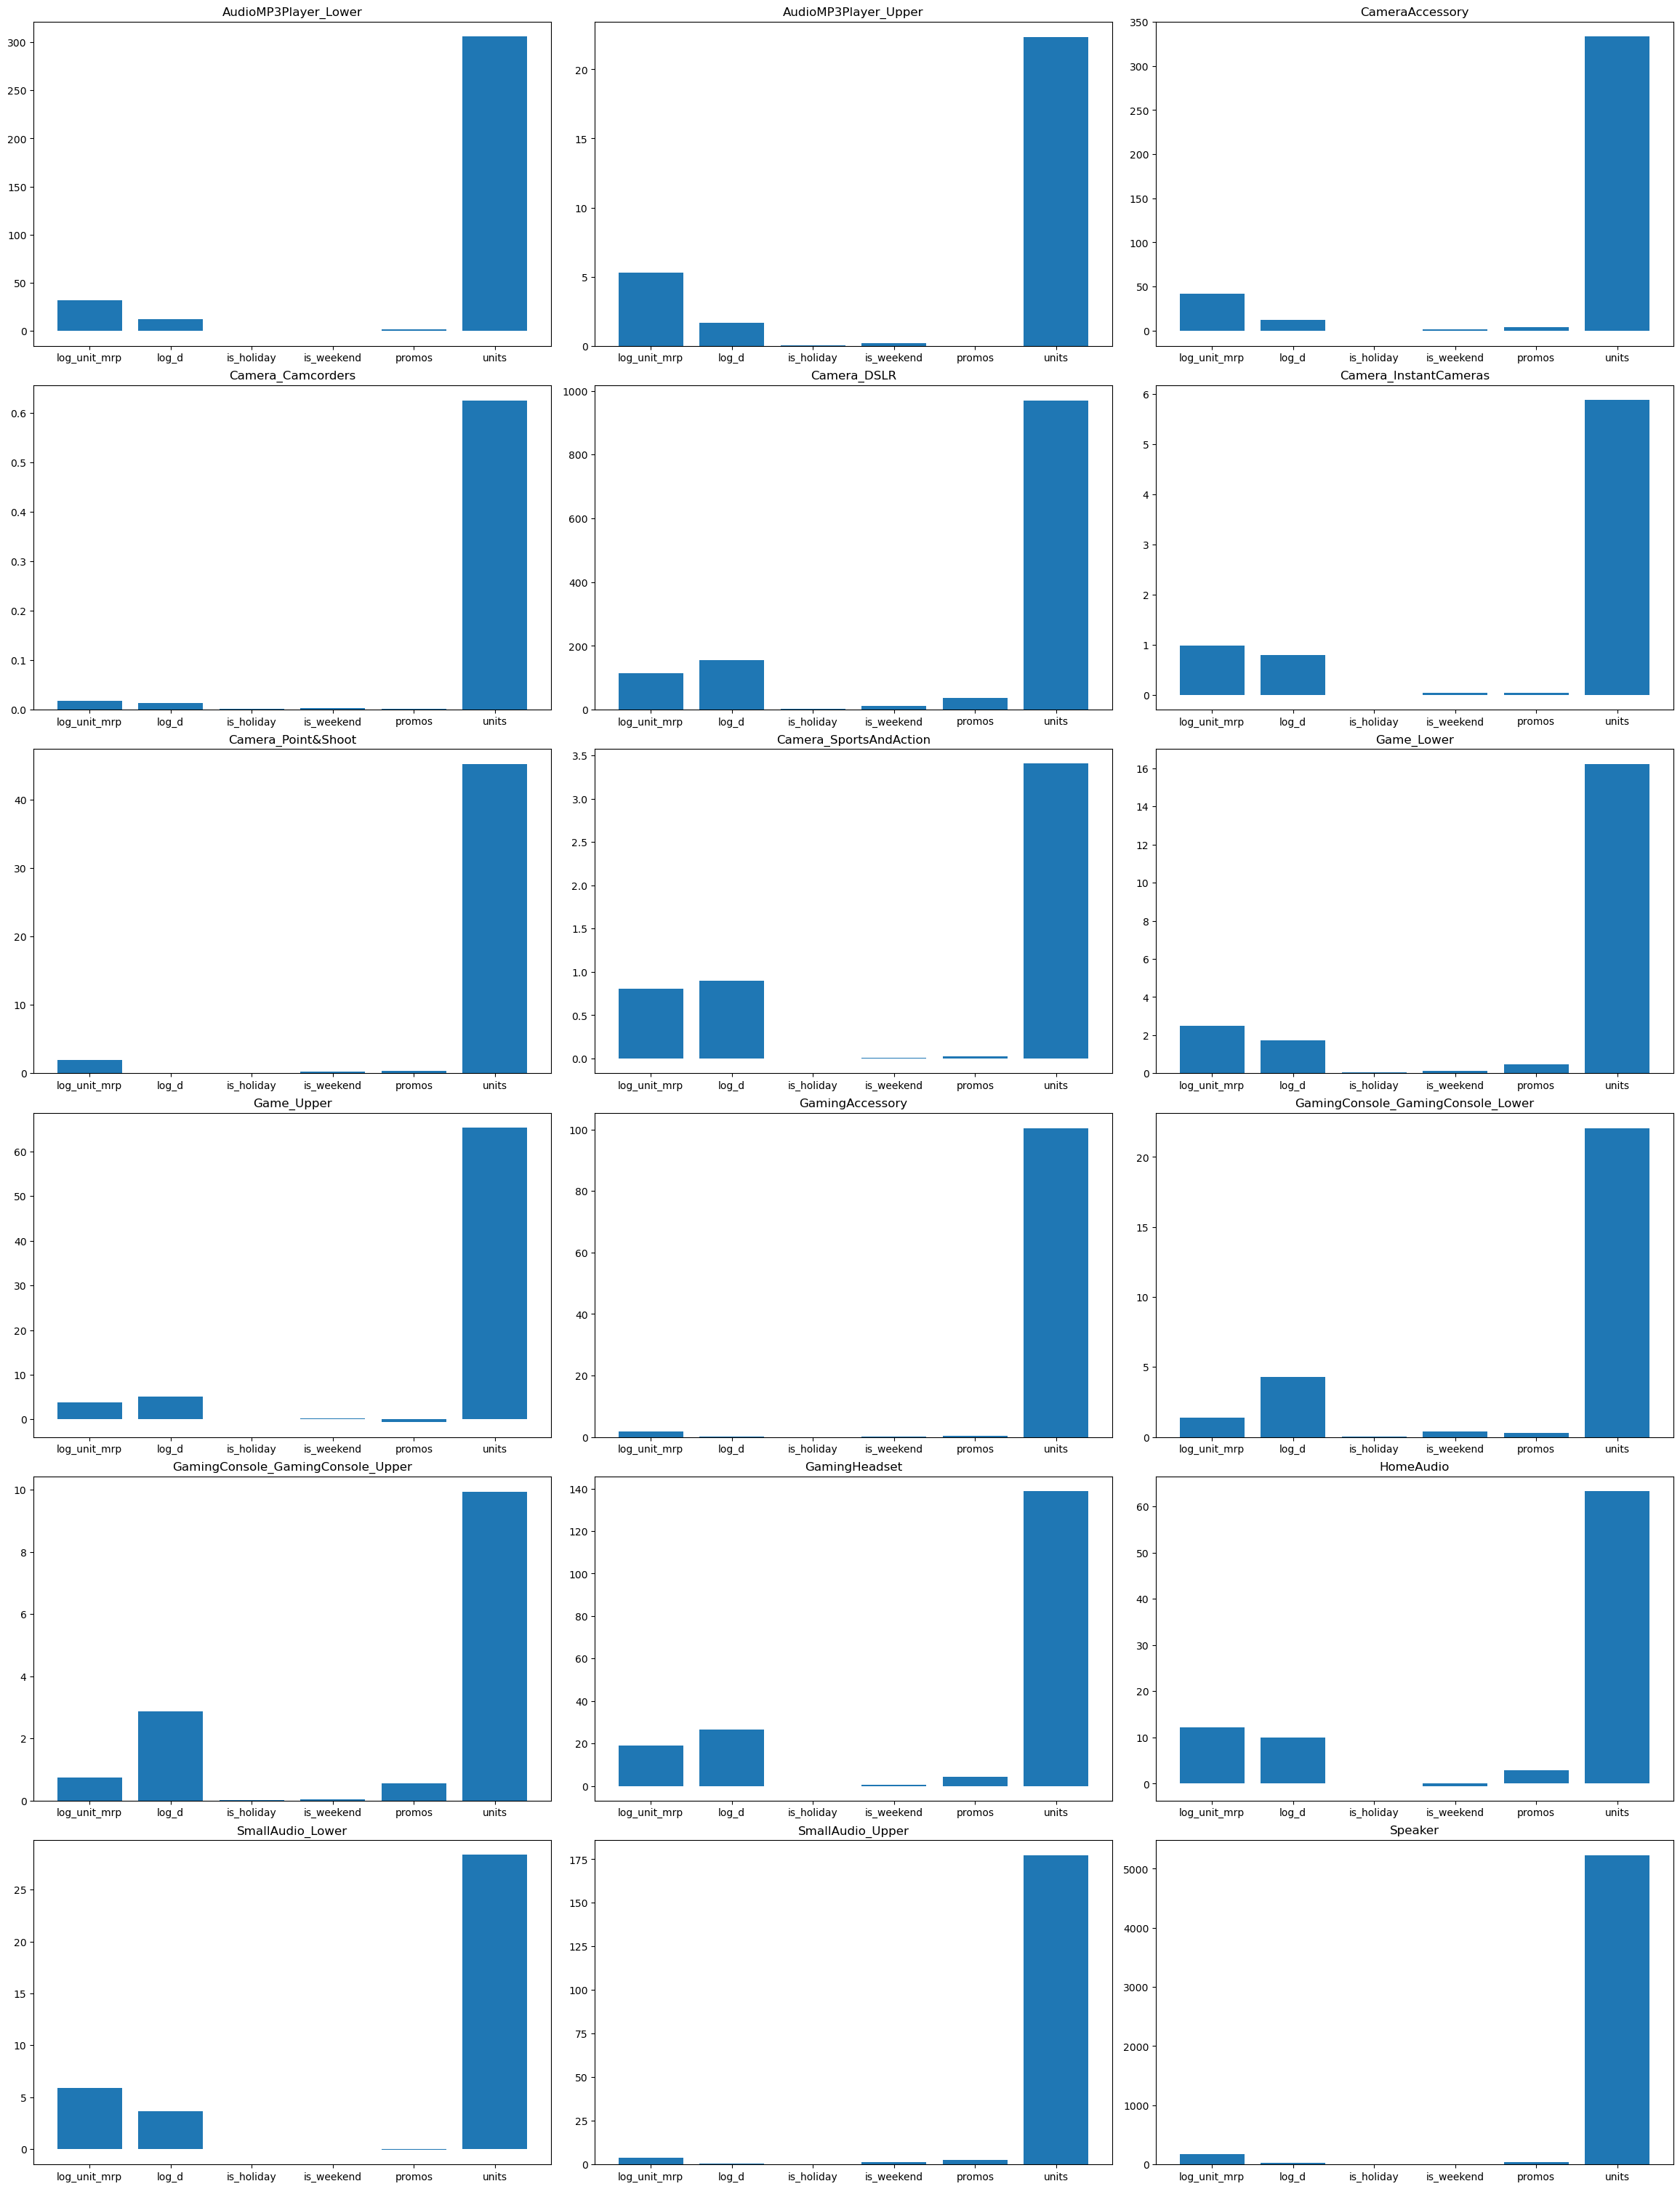

In [34]:
fig, axs = plt.subplots(6,3,figsize=(23,30),layout='constrained')

targets = zip(name_dict.keys(), axs.flatten())
columns = list(ics_units['HomeAudio'].keys())

for i, (name,ax) in enumerate(targets):
    ax.set_title(name)
    ax.bar(x=columns,height=ics_units[name].values())
    ax.set_ylabel('')

#### Psuedo experiments


With some understanding of how much each variable would affect the unit demand and GMV, we can make ask a new extension as follows.

One further use case of the aboves model is to anticipate if we gave more discounts, what could happen? Let's say we decrease the price by 0.3% (as profit margins for retail is low, 0.3% is considered high), what do we anticipate the different revenue streams to be like if we ran a pseudo experiment. In particular, for Speakers and Camera DSLR? 

In [19]:
scm = gcm.StructuralCausalModel(causal_graph)
    
gcm.auto.assign_causal_mechanisms(scm,flc[flc.new_cat=='Camera_DSLR'], override_models=True,quality=gcm.auto.AssignmentQuality.GOOD)  
scm.set_causal_mechanism('promos',gcm.ClassifierFCM(classifier_model=gcm.ml.classification.create_logistic_regression_classifier(),
                                            )
                        )  
gcm.fit(scm, flc[flc.new_cat=='Camera_DSLR'])

def estimate_sim_dslr():
    return gcm.average_causal_effect(scm,
                                    "gmv_new",
                                    {"log_d": lambda x: np.log(np.exp(x) - 0.003) },
                                     {"log_d": lambda x: x},
                                      flc[(flc.new_cat=='Camera_DSLR')&(flc.special_dates==0)].sample(30)
                                      )

def estimate_sim_speaker():
    return gcm.average_causal_effect(scm,
                                    "gmv_new",
                                    {"log_d": lambda x: np.log(np.exp(x) - 0.003) },
                                     {"log_d": lambda x: x},
                                      flc[(flc.new_cat=='Speaker')&(flc.special_dates==0)].sample(30)
                                      )


ace_camera_median, ace_camera_ci = gcm.confidence_intervals(estimate_sim
                                        , num_bootstrap_resamples=1000
                                        )

gcm.fit(scm, flc[flc.new_cat=='Speaker'])


ace_speaker_median, ace_speaker_ci = gcm.confidence_intervals(estimate_sim_speaker
                                        , num_bootstrap_resamples=1000
                                        )

Estimating bootstrap interval...: 100%|████████████████████████████████████████████| 1000/1000 [00:22<00:00, 44.50it/s]


After bootstrapping, if we increase Camera discount by 0.3% on average, we could see an increase of up to 3% in revenue for Camera. This is risky as the CI does show it may decrease the revenue. Whereas for speakers, we don't see as large potential increase in revenue, but there's is less risk. It would be worth running the experiment on the Camera and Speakers given the detected effect size is not that small and that the Bayesian model validates that there is a good chance that the discount effect would at the very least be postive.

In [28]:
# As these are log revenue, we have to interpret the increases as % increases. 

print("% increase GMV median ~ "+str(ace_camera_median[0]*100))
print("95% CI ~ "+str([i*100 for i in ace_camera_ci[0]]))

% increase GMV median ~ 3.301077077205762
95% CI ~ [-24.06780119285798, 32.41357707979974]


In [29]:
print("% increase GMV median ~ "+str(ace_speaker_median[0]*100))
print("95% CI ~ "+str([i*100 for i in ace_speaker_ci[0]]))

% increase GMV median ~ 0.9350201538250545
95% CI ~ [-15.466651583215041, 16.83528299971829]


#### Anomaly attributions

The next question is also can we explain the anomalies seen in October on April on the few particular days? Let's go for October first.

First, we observe a large difference in the units that were purchased between Oct/Apr vs the rest of the year.


In [88]:
pd.concat([flc[flc.Date.isin(['2015-10-14','2015-10-15','2015-10-16','2015-10-17'])
].groupby('new_cat').units.mean().rename('oct'),
flc[flc.Date.isin(['2016-04-27'])
].groupby('new_cat').units.mean().rename('apr'),
 flc[flc.special_dates==0
].groupby('new_cat').units.mean().rename('reg')
          ],axis=1)

,oct,apr,reg
new_cat,,,
AudioMP3Player_Lower,6.921057,7.884577,5.543309
AudioMP3Player_Upper,4.426583,5.480639,3.574687
CameraAccessory,7.502764,8.728588,6.472087
Camera_Camcorders,1.242453,3.871201,0.874172
Camera_DSLR,6.227713,6.824374,4.828658
Camera_Instant Cameras,1.716733,3.828641,1.793097
Camera_Point & Shoot,6.356679,6.514713,4.485873
Camera_SportsAndAction,1.656604,4.369448,1.846682
Game_Lower,5.246267,6.679599,4.346419


For October, we don't see any strong signals based on the SHAP analysis of the difference in distribution that seem to indicate why there was more increased demand on that particular area. Moreover, it does seem consistent between different products that there is no standout candidate the caused the variations here.

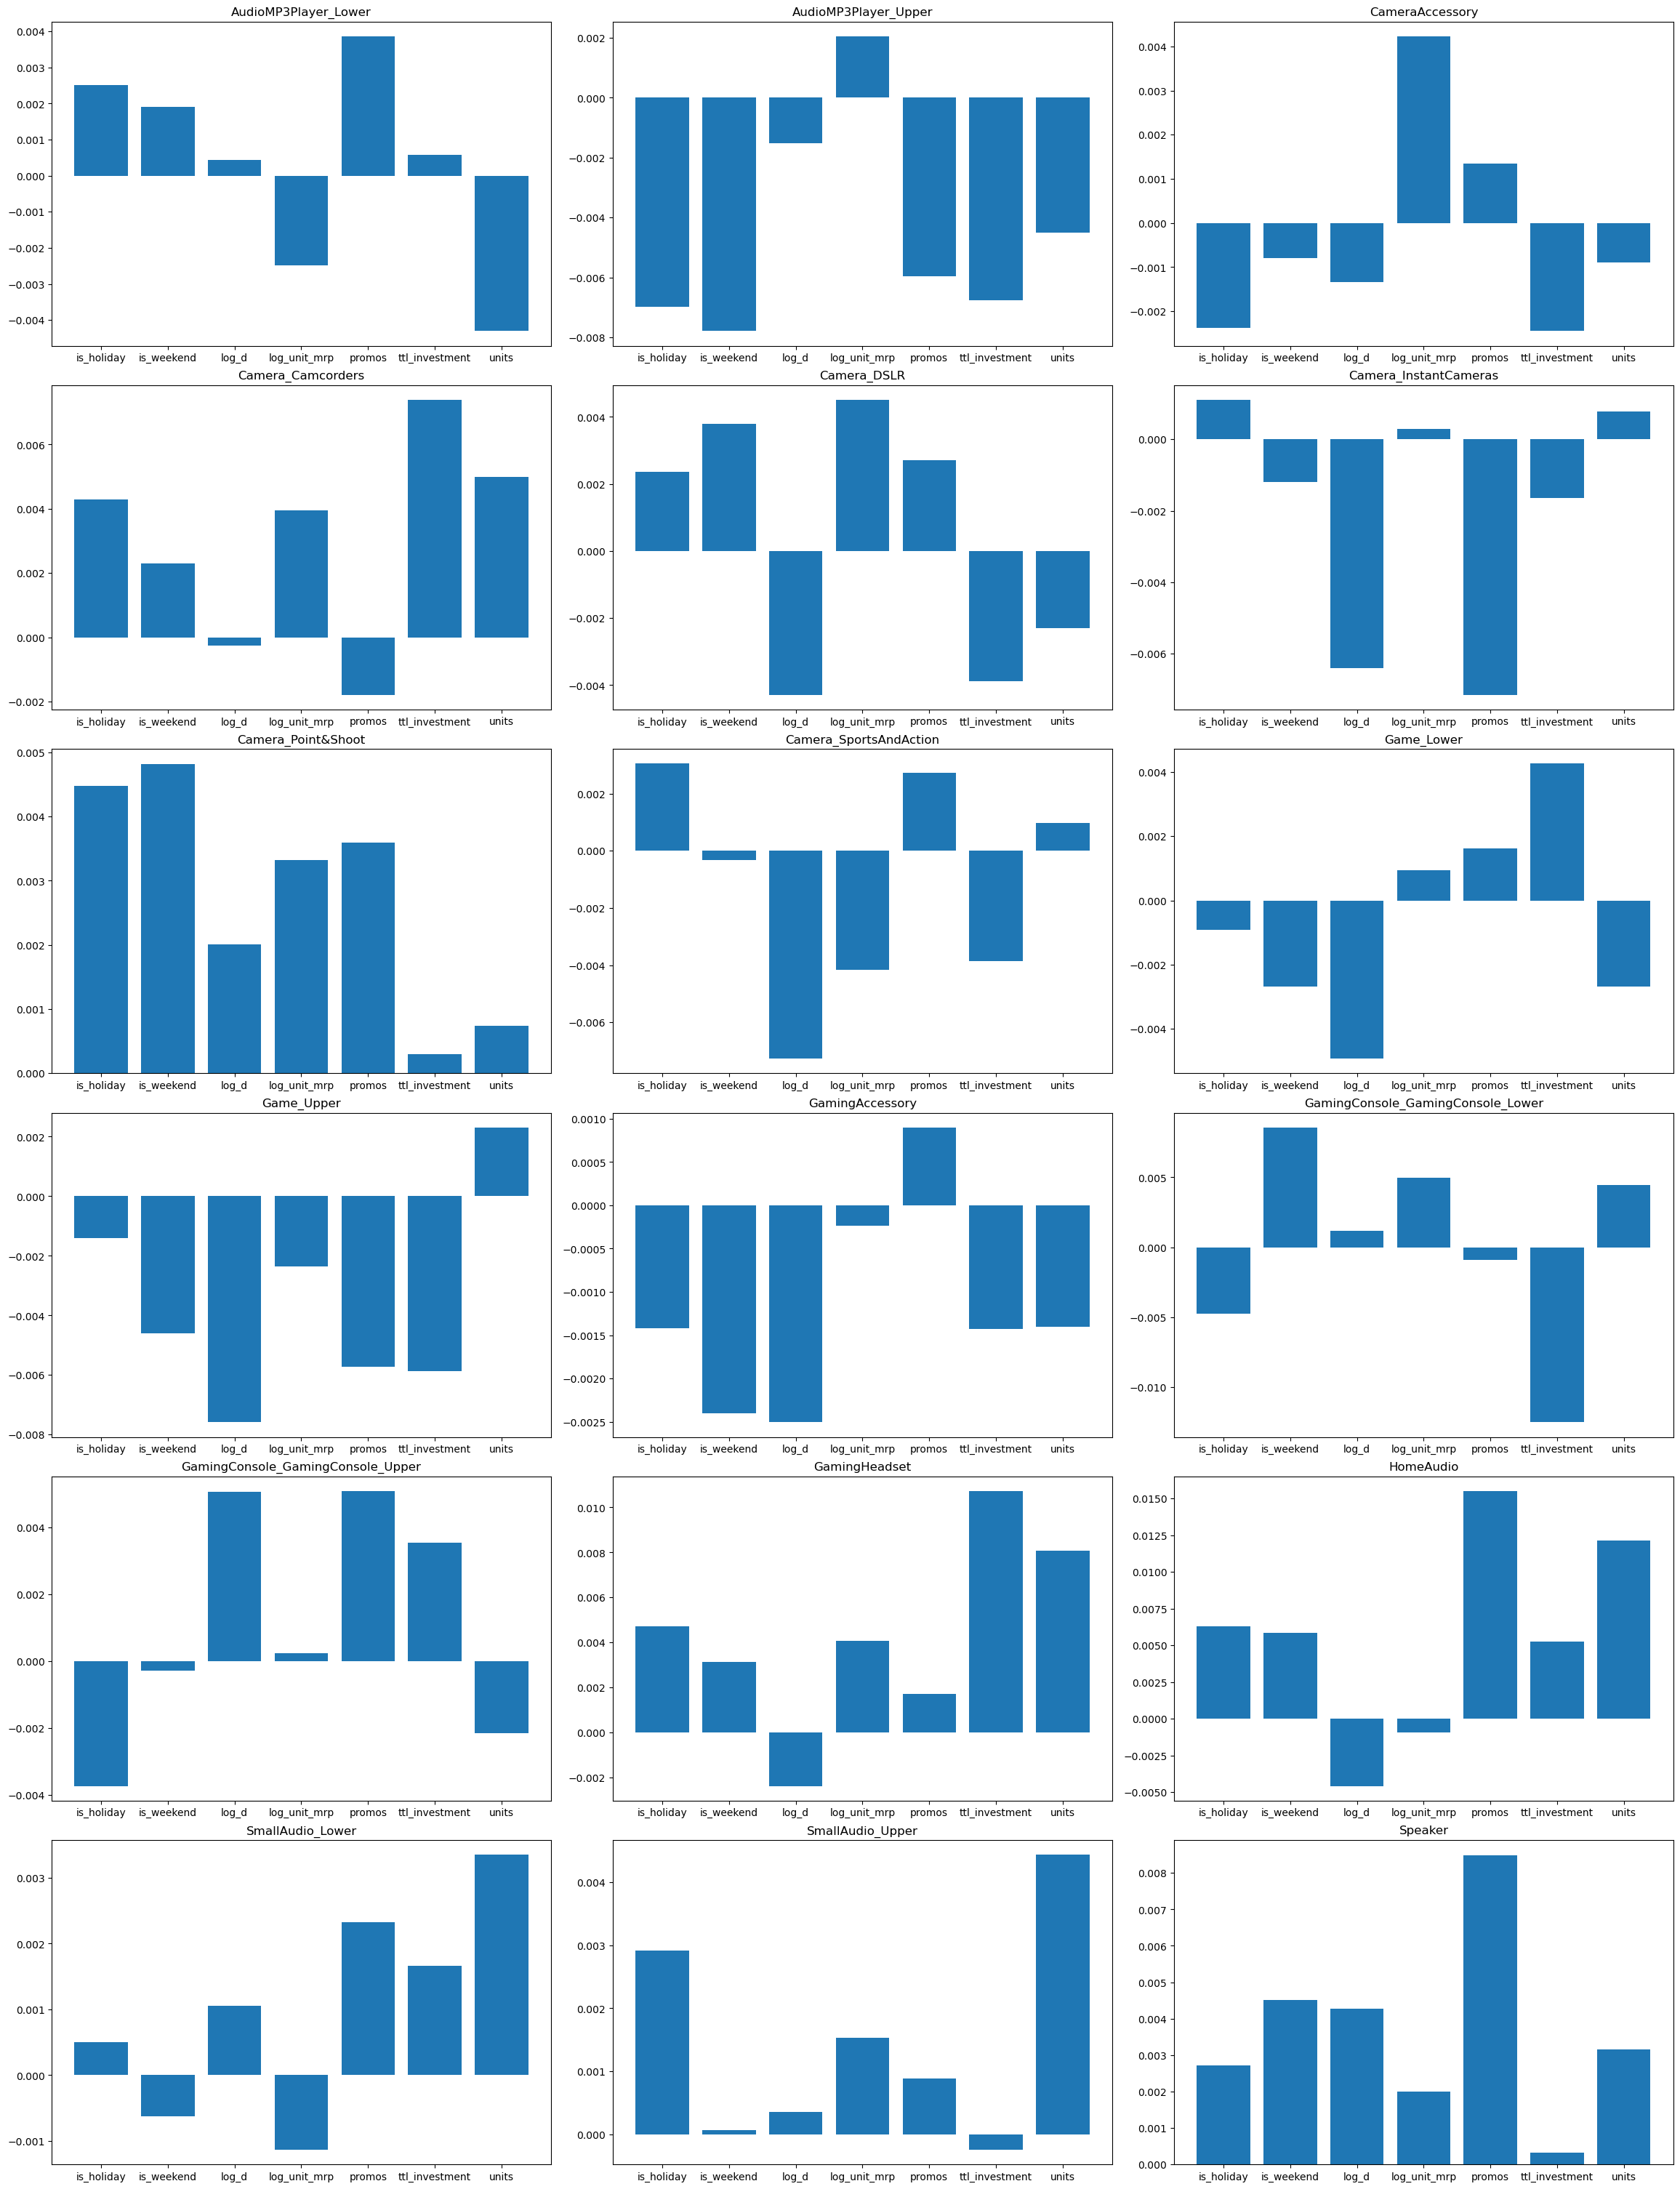

In [71]:
fig, axs = plt.subplots(6,3,figsize=(23,30),layout='constrained')

targets = zip(name_dict.keys(), axs.flatten())
columns = list(oct_anom['HomeAudio'].keys())

for i, (name,ax) in enumerate(targets):
    ax.set_title(name)
    ax.bar(x=columns,height=oct_anom[name].values())
    ax.set_ylabel('')

In [5]:
# Respecify only for April effect model as it can't do anomaly attribution.
flc['promos'] = flc.promos.astype(int)
icc_apr_dict={}
 
for name, group in flc.groupby('new_cat'):
    scm = gcm.StructuralCausalModel(causal_graph)
        
    gcm.auto.assign_causal_mechanisms(scm,group, override_models=True,quality=gcm.auto.AssignmentQuality.GOOD)  
    gcm.fit(scm, group)
    
        # Explore intrinsic effects first.
    
    iccs_apr = gcm.attribute_anomalies(scm, target_node='units', 
                            anomaly_samples=group[(group.Date.isin(['2016-04-27',]))])
    icc_apr_dict.update({name: iccs_apr
                     }
                    )

Fitting causal mechanism of node is_weekend: 100%|███████████████████████████████████████| 8/8 [00:00<00:00, 12.96it/s]
Estimating Shapley Values. Average change of Shapley values in run 21 (105 evaluated permutations): 2.485646034340774%:
Fitting causal mechanism of node is_weekend: 100%|███████████████████████████████████████| 8/8 [00:00<00:00, 26.20it/s]
Estimating Shapley Values. Average change of Shapley values in run 117 (585 evaluated permutations): 0.4729729316617581
Fitting causal mechanism of node is_weekend: 100%|███████████████████████████████████████| 8/8 [00:00<00:00, 27.39it/s]
Estimating Shapley Values. Average change of Shapley values in run 56 (280 evaluated permutations): 1.207841187708758%:
Fitting causal mechanism of node is_weekend: 100%|███████████████████████████████████████| 8/8 [00:00<00:00, 24.03it/s]
Estimating Shapley Values. Average change of Shapley values in run 18 (90 evaluated permutations): 1.1160823160196065%:
Fitting causal mechanism of node is_week

In [3]:
mem_str_apr = """{'AudioMP3Player_Lower': {'ttl_investment': array([-0.51947118]),
  'is_holiday': array([0.]),
  'is_weekend': array([0.16610751]),
  'promos': array([0.]),
  'log_d': array([1.79222307]),
  'log_unit_mrp': array([1.61383908]),
  'units': array([3.34456445])},
 'AudioMP3Player_Upper': {'ttl_investment': array([0.0023798]),
  'is_holiday': array([-0.04476723]),
  'is_weekend': array([-0.06348711]),
  'promos': array([0.]),
  'log_d': array([-0.13342742]),
  'log_unit_mrp': array([-0.00900489]),
  'units': array([5.42179434])},
 'CameraAccessory': {'ttl_investment': array([0.23762069]),
  'is_holiday': array([-0.00346371]),
  'is_weekend': array([0.07984102]),
  'promos': array([0.]),
  'log_d': array([0.44818535]),
  'log_unit_mrp': array([0.01791161]),
  'units': array([5.61716798])},
 'Camera_Camcorders': {'ttl_investment': array([1.25264539]),
  'is_holiday': array([0.]),
  'is_weekend': array([0.29701646]),
  'promos': array([0.]),
  'log_d': array([0.83364858]),
  'log_unit_mrp': array([0.27156654]),
  'units': array([5.35182387])},
 'Camera_DSLR': {'ttl_investment': array([0.73708436]),
  'is_holiday': array([0.]),
  'is_weekend': array([0.01917139]),
  'promos': array([0.]),
  'log_d': array([-1.53865531]),
  'log_unit_mrp': array([1.65822661]),
  'units': array([3.41730173])},
 'Camera_Instant Cameras': {'ttl_investment': array([-0.6842277]),
  'is_holiday': array([0.]),
  'is_weekend': array([0.44707073]),
  'promos': array([0.]),
  'log_d': array([2.4800224]),
  'log_unit_mrp': array([0.87825031]),
  'units': array([4.8855851])},
 'Camera_Point & Shoot': {'ttl_investment': array([-0.04497812]),
  'is_holiday': array([0.]),
  'is_weekend': array([0.04075057]),
  'promos': array([0.]),
  'log_d': array([2.71490557]),
  'log_unit_mrp': array([1.11370236]),
  'units': array([4.18232047])},
 'Camera_SportsAndAction': {'ttl_investment': array([0.4081002]),
  'is_holiday': array([0.]),
  'is_weekend': array([0.2029086]),
  'promos': array([0.]),
  'log_d': array([1.32064937]),
  'log_unit_mrp': array([0.99124633]),
  'units': array([5.08379634])},
 'Game_Lower': {'ttl_investment': array([0.11381051]),
  'is_holiday': array([0.]),
  'is_weekend': array([0.04112619]),
  'promos': array([0.]),
  'log_d': array([2.36671573]),
  'log_unit_mrp': array([0.09401484]),
  'units': array([5.39103356])},
 'Game_Upper': {'ttl_investment': array([-0.29242191]),
  'is_holiday': array([0.]),
  'is_weekend': array([-0.04499471]),
  'promos': array([0.]),
  'log_d': array([3.33290906]),
  'log_unit_mrp': array([0.83990678]),
  'units': array([4.17130162])},
 'GamingAccessory': {'ttl_investment': array([0.08093364]),
  'is_holiday': array([0.00121176]),
  'is_weekend': array([0.01017325]),
  'promos': array([0.]),
  'log_d': array([0.38175262]),
  'log_unit_mrp': array([0.23194253]),
  'units': array([5.69124914])},
 'GamingConsole_GamingConsole_Lower': {'ttl_investment': array([0.25269904]),
  'is_holiday': array([-0.00102146]),
  'is_weekend': array([0.00290287]),
  'promos': array([0.06816233]),
  'log_d': array([1.88534828]),
  'log_unit_mrp': array([-0.62400687]),
  'units': array([3.85766729])},
 'GamingConsole_GamingConsole_Upper': {'ttl_investment': array([-0.21251937]),
  'is_holiday': array([0.]),
  'is_weekend': array([0.15569874]),
  'promos': array([0.]),
  'log_d': array([-0.01851714]),
  'log_unit_mrp': array([1.43493708]),
  'units': array([3.60257911])},
 'GamingConsole_HandheldGamingConsole_Lower': {'ttl_investment': array([0.95713655]),
  'is_holiday': array([0.]),
  'is_weekend': array([0.05628899]),
  'promos': array([0.]),
  'log_d': array([0.86509828]),
  'log_unit_mrp': array([1.14595874]),
  'units': array([4.98221829])},
 'GamingConsole_HandheldGamingConsole_Upper': {'ttl_investment': array([0.72789371]),
  'is_holiday': array([0.]),
  'is_weekend': array([0.14921332]),
  'promos': array([0.]),
  'log_d': array([-0.32273334]),
  'log_unit_mrp': array([1.77465877]),
  'units': array([3.11271902])},
 'GamingHeadset': {'ttl_investment': array([-0.71505089]),
  'is_holiday': array([0.]),
  'is_weekend': array([0.37864334]),
  'promos': array([0.]),
  'log_d': array([1.76465662]),
  'log_unit_mrp': array([1.4681915]),
  'units': array([5.11026028])},
 'HomeAudio': {'ttl_investment': array([0.43828131]),
  'is_holiday': array([0.]),
  'is_weekend': array([0.0183804]),
  'promos': array([0.]),
  'log_d': array([1.6703348]),
  'log_unit_mrp': array([0.44582674]),
  'units': array([5.43387759])},
 'SmallAudio_Lower': {'ttl_investment': array([0.83149858]),
  'is_holiday': array([0.]),
  'is_weekend': array([0.08380861]),
  'promos': array([0.]),
  'log_d': array([1.61168565]),
  'log_unit_mrp': array([0.67391719]),
  'units': array([4.80579082])},
 'SmallAudio_Upper': {'ttl_investment': array([0.66713657]),
  'is_holiday': array([0.]),
  'is_weekend': array([0.05811046]),
  'promos': array([0.]),
  'log_d': array([1.2516964]),
  'log_unit_mrp': array([0.58238967]),
  'units': array([3.83792983])},
 'Speaker': {'ttl_investment': array([-0.6109105]),
  'is_holiday': array([0.]),
  'is_weekend': array([0.14038079]),
  'promos': array([0.]),
  'log_d': array([1.71964157]),
  'log_unit_mrp': array([0.64857515]),
  'units': array([3.27580049])}}"""

In [5]:
mem_str_apr = mem_str_apr.replace('array([','').replace('])','').replace(' ','').replace('\n','')
icc_apr_dict = ast.literal_eval(mem_str_apr)

For April, we see a similar logic, where although discounts can play a part in terms of increasing the unit count , this is not fully conclusive, and there is still a lot of unattributed causes from the units itself causing the large changes here. There may be more causes of the anomalies that may need more data to understand that is not discount or pricing data.

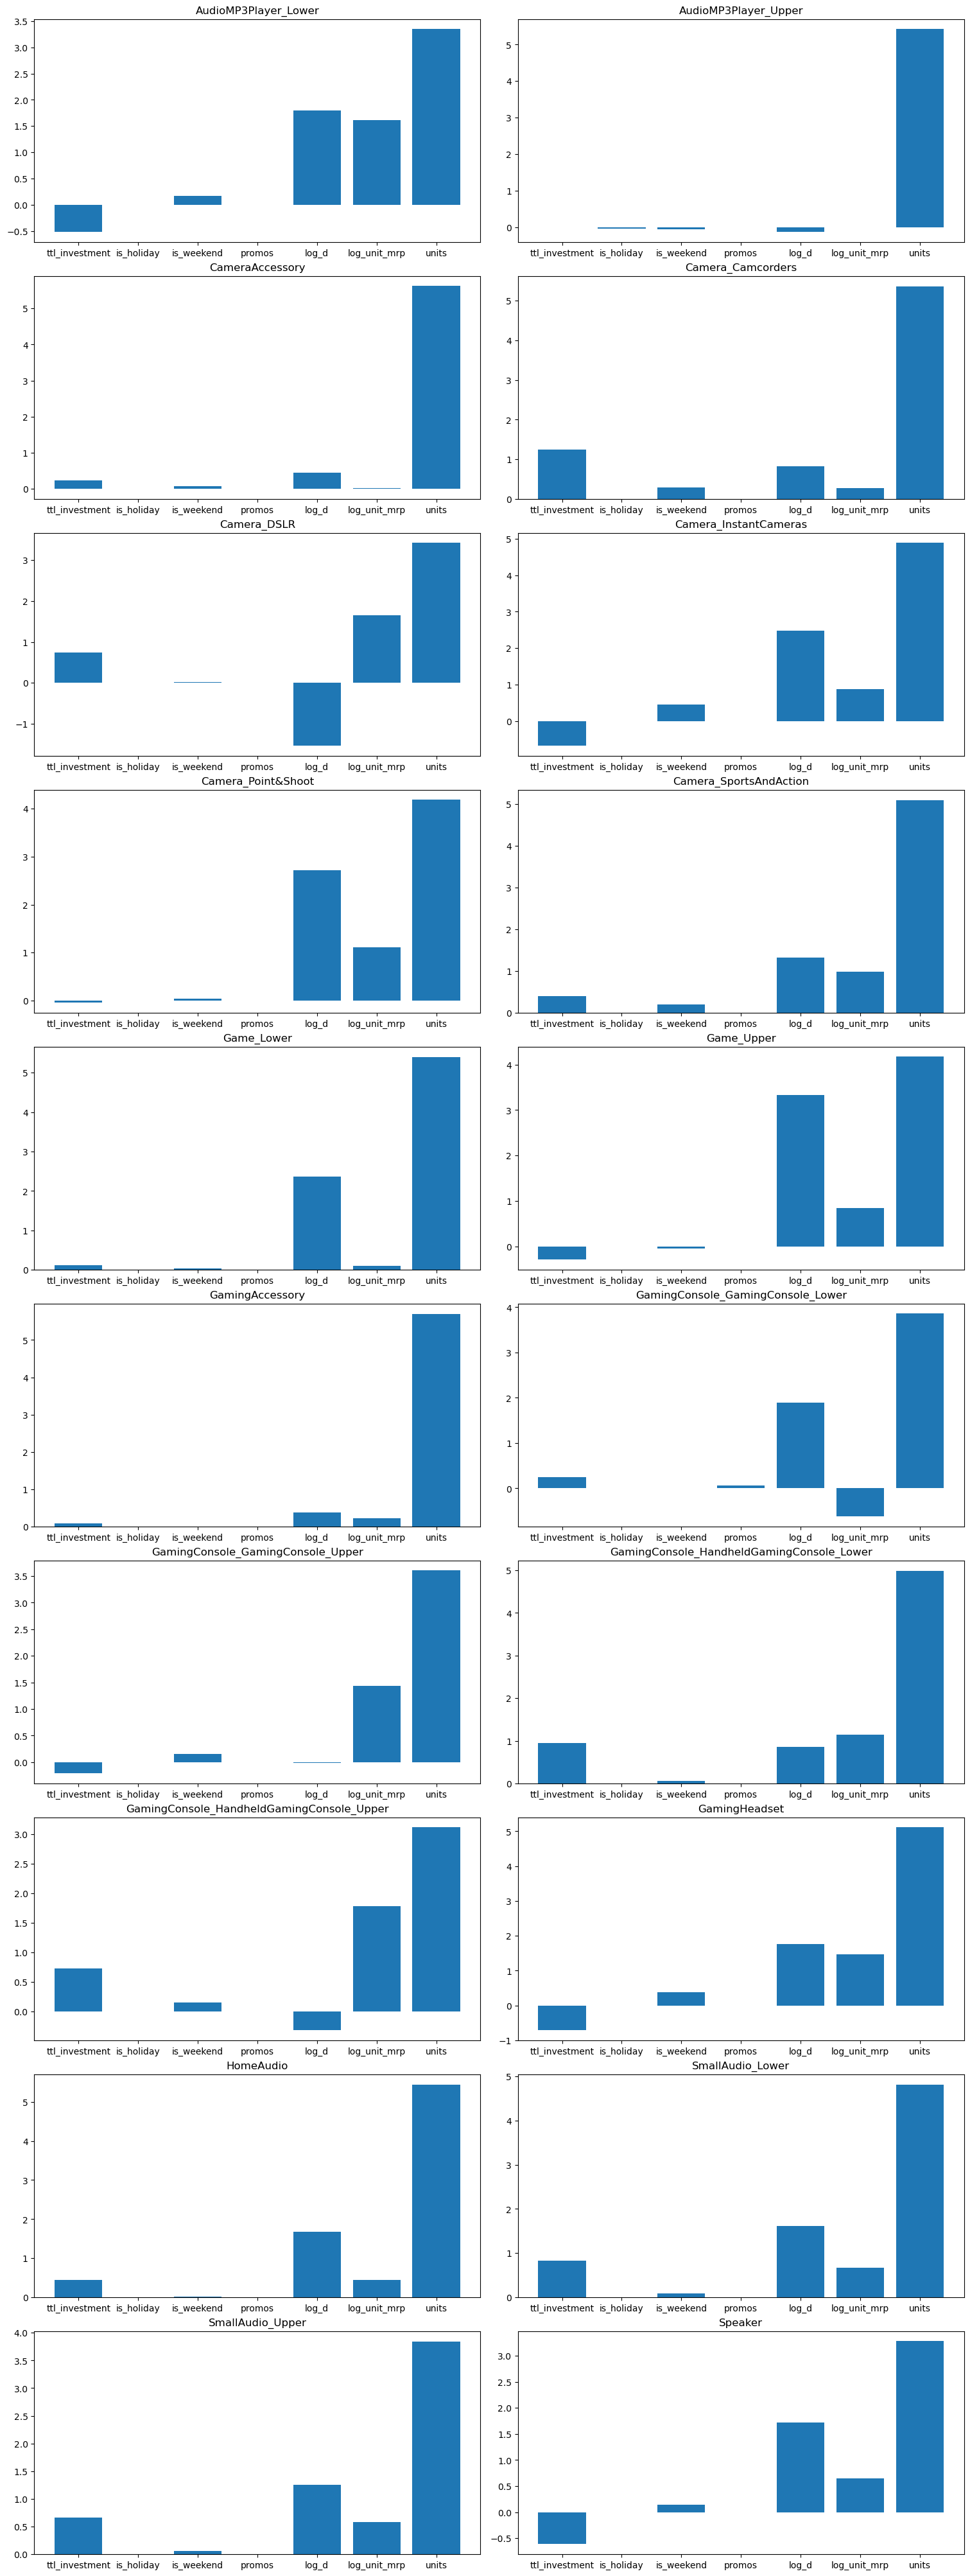

In [8]:
fig, axs = plt.subplots(10,2,figsize=(15,40),layout='constrained')

targets = zip(icc_apr_dict.keys(), axs.flatten())
columns = list(icc_apr_dict['HomeAudio'].keys())

for i, (name,ax) in enumerate(targets):
    ax.set_title(name)
    ax.bar(x=columns,height=icc_apr_dict[name].values())
    ax.set_ylabel('')

### Explaining total investment

Going back to high level, we discussed previous that we wanted to relook into total investment given that our analysis indicated that there was more to explore.

We will create one more model that allows us to determine the importance of marketing relative to our other factors on a monthly level. This will also be split by product. For assumption, we will assume that marketing acts on both unit supply and pricing to try to capture the causal structure given that we've done so for the Bayesian mixed model. We should expect there to be some effect if our different models have indicated here.

In [31]:
flc['Date'] = pd.to_datetime(flc.Date)
flc['MonthStart'] = flc.Date - pd.to_timedelta(flc['Date'].dt.day - 1,'D')
flc['units_exp'] = np.exp(flc.units)
flc['gmv_exp'] = np.exp(flc.gmv_new)


In [75]:
marketing_data['Date'] = pd.to_datetime(marketing_data['Date'])
gmv = marketing_data[category_columns+['Date']].set_index('Date').unstack(
    
).rename('gmv_new').swaplevel()
gmv.index.set_names(['MonthStart','new_cat'],inplace=True)

In [102]:
ovl_names = pd.concat([
    flc.groupby(['MonthStart','new_cat'])[['log_unit_mrp','log_d']].mean(),
    np.log(flc.groupby(['MonthStart','new_cat']).units_exp.sum()),
    flc.groupby(['MonthStart','new_cat']).ttl_investment.sum(),
    np.log(flc.groupby(['MonthStart','new_cat']).gmv_exp.sum()),
],axis=1).reset_index()
ovl_names['gmv_new'] = ovl_names['gmv_exp'] 


In [121]:
causal_graph_agg = nx.DiGraph([
                          ('log_unit_mrp','units_exp'),('log_unit_mrp','gmv_new'),
                        ('ttl_investment','units_exp'),('ttl_investment','units_exp'),
                    ('ttl_investment','log_unit_mrp'),
                           ('log_d','units_exp'),('log_d','gmv_new'),
                           ('units_exp','gmv_new'),
                          ])

In [122]:
icc_ovl = {}

for name, group in ovl_names.groupby('new_cat'):
    scm = gcm.StructuralCausalModel(causal_graph_agg)
        
    auto_assignment_summary = gcm.auto.assign_causal_mechanisms(scm,group, 
                                            override_models=True,quality=gcm.auto.AssignmentQuality.GOOD)  
    gcm.fit(scm, group)
    
        # Explore intrinsic effects first.
    
    iccs = gcm.intrinsic_causal_influence(scm, target_node='gmv_new', num_samples_randomization=500)
    icc_ovl.update({name: iccs
                     }
                    )

Fitting causal mechanism of node log_d: 100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 48.38it/s]
Evaluate set function: 32it [00:00, 43.90it/s]
Fitting causal mechanism of node log_d: 100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 95.62it/s]
Evaluate set function: 32it [00:00, 43.68it/s]
Fitting causal mechanism of node log_d: 100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 58.98it/s]
Evaluate set function: 32it [00:05,  6.34it/s]
Fitting causal mechanism of node log_d: 100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 51.38it/s]
Evaluate set function: 32it [00:00, 46.54it/s]
Fitting causal mechanism of node log_d: 100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 110.72it/s]
Evaluate set function: 32it [00:00, 42.47it/s]
Fitting causal mechanism of node log_d: 100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 68.13it/s]
Evaluate set function: 32it [00:00, 42.95it/s

In [123]:
icc_ovl

{'AudioMP3Player_Lower': {'ttl_investment': -8.101745908969563e-17,
  'log_d': 0.0028018842624221757,
  'log_unit_mrp': 0.007089809601682302,
  'units_exp': 0.010793784566815685,
  'gmv_new': 0.00020115492259727868},
 'AudioMP3Player_Upper': {'ttl_investment': 0.0093235166112865,
  'log_d': 0.0024946074435873403,
  'log_unit_mrp': 0.0001330894849400311,
  'units_exp': 0.005199204988335416,
  'gmv_new': 0.0009998466887958626},
 'CameraAccessory': {'ttl_investment': 1.671116948523792e-17,
  'log_d': 4.0997298148916993e-17,
  'log_unit_mrp': 4.6635149445851033e-17,
  'units_exp': 3.087807787238847e-17,
  'gmv_new': 0.009352766823664328},
 'Camera_Camcorders': {'ttl_investment': 6.287559448789793e-17,
  'log_d': 0.0004850981194665109,
  'log_unit_mrp': 0.0829864796185451,
  'units_exp': 0.23621893296787036,
  'gmv_new': 0.0007857082454507232},
 'Camera_DSLR': {'ttl_investment': 0.022057975407150834,
  'log_d': 0.00046544108796571883,
  'log_unit_mrp': 0.0005169699236035733,
  'units_exp': 

The graph below shows quite a surprising result. It seems that total investment does play a role, but it may be focused in certain product categories compared to others (e.g Camera DSLR and Speakers), which may make sense given that these are the top 2 categories for spending. For the others, it is not strongly conclusive that total investment has a strong or medium effect, but there is more evidence to suggest that there is some effect for some categories. 

Overall, given the small volume of data, we will not conclude anything for the DSLR/Speakers in terms of the total investment effect here, other than, we do observe that it is worth spending more overall on all products overall.

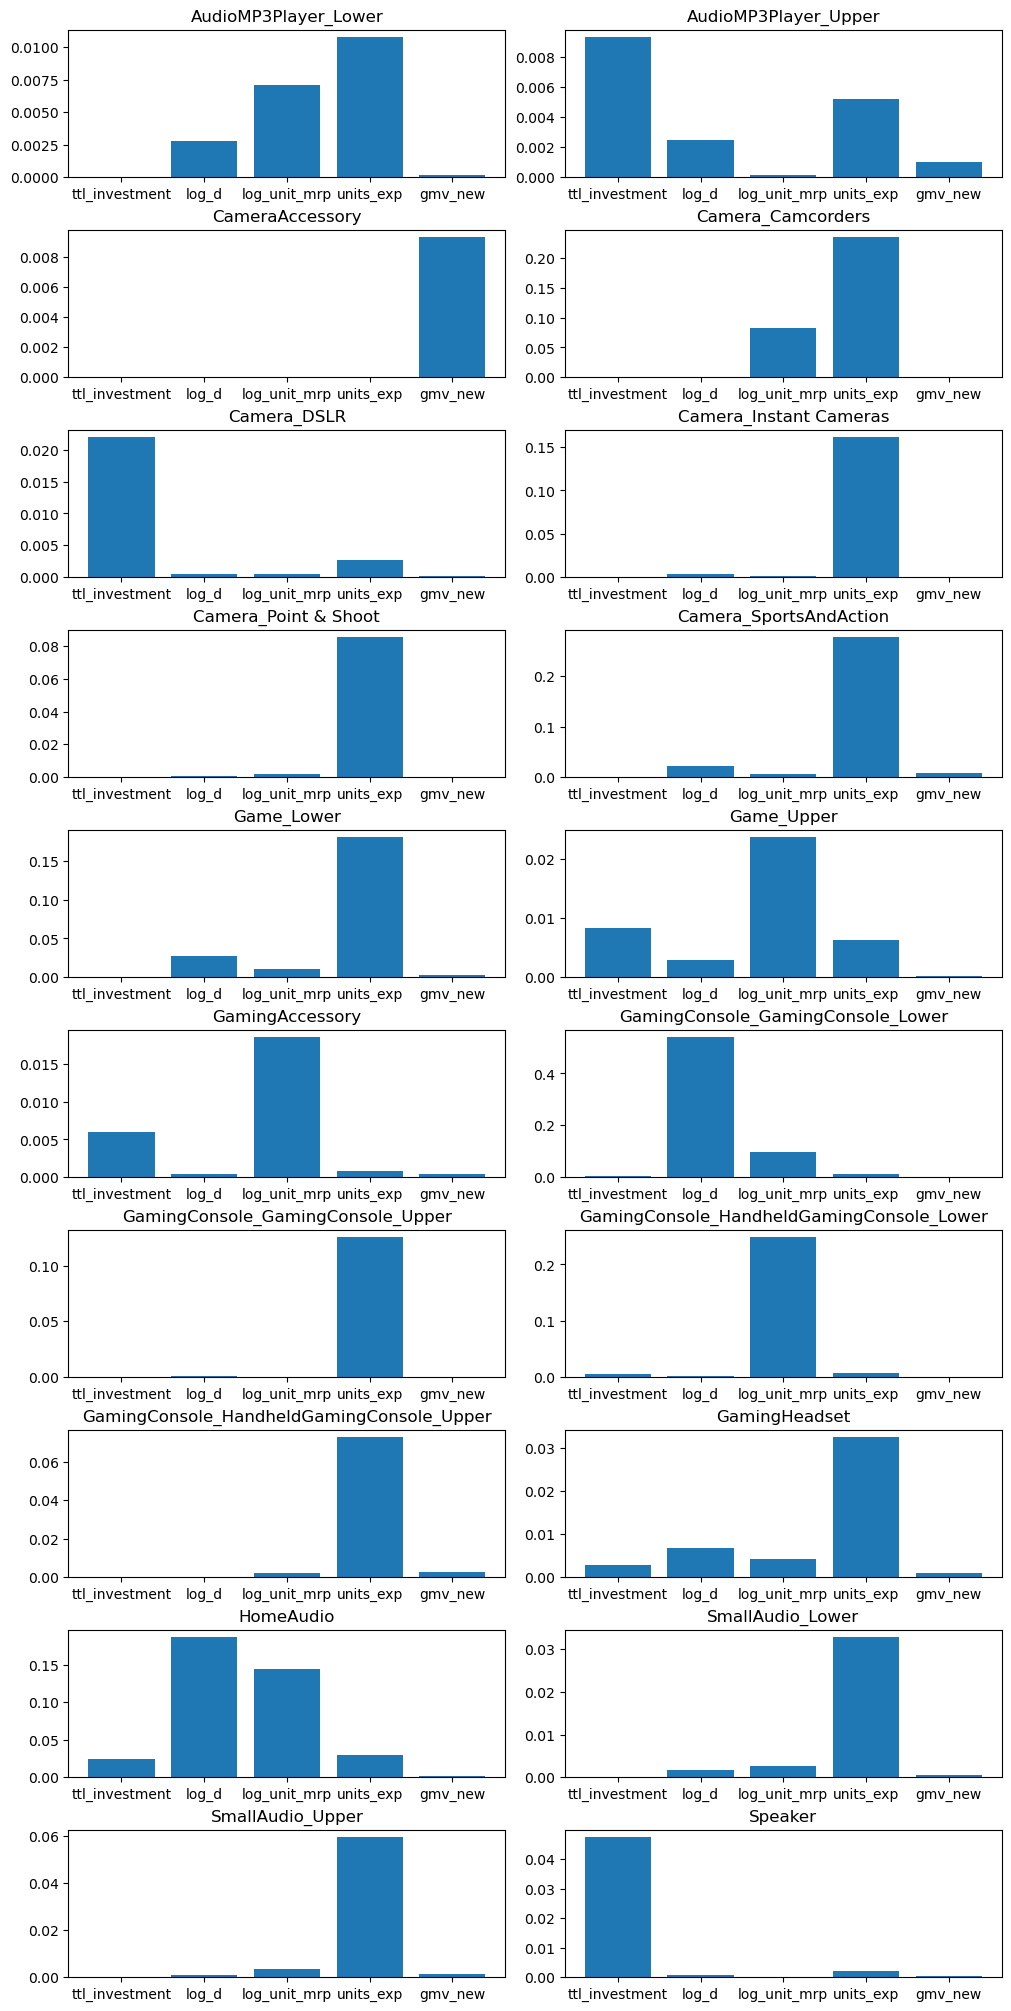

In [127]:
fig, axs = plt.subplots(10,2,figsize=(10,20),layout='constrained')

targets = zip(icc_ovl.keys(), axs.flatten())
columns = list(icc_ovl['HomeAudio'].keys())

for i, (name,ax) in enumerate(targets):
    ax.set_title(name)
    ax.bar(x=columns,height=icc_ovl[name].values())
    ax.set_ylabel('')

## Takeaways

Based on the analysis above, we have a few takeaways.

1. Total discount as confirmed by the Bayesian model is effective in terms of an area to experiment. We would recommend experimenting with Camera DSLR/Speakers, as this could yield 1-3% lift in revenue for some 0.3% discount.
2. Given that total marketing spending has some effect to increase revenue, especially in focused areas, we would recommend to spend more in this area uniformly across all products as saturation point has not been hit yet. We would also recommend getting more data in terms of attributing specific campaigns to product for better analysis in the future. If total marketing is focused only on the certain areas that we see, then we suggest branching out and getting the data to study that effect. Affiliates could be a point of investigation given strong suggestion of effect here.
3. We don't see strong effect via weekend/holiday/promo demands. Nonetheless, given promo has some effect and discounts will actually play a huge role in terms of encouraging purchase, we also recommend focusing on this area in the future where possible. One could follow the example of China on specific dates of attracting more sales. For said campaigns, focus on the discounts.
4. In terms of a general focus, discounts + promo optimization would be the first, followed by total marketing spend.
5. If it is possible to obtain data on user attributes, it's possible to look at other factor that affects unit spending besides price and discounting. 
6. Follow up on the anomalies, as there may be more data points that may indicate why we are seeing a spike in spend in that area that may have learnings.
7. For NPS and customer satisfaction, we will also need more data in the future to investigate here, and in particular, vendor related data and NPS score if possible deriving from the particular customer. 

## Appendix

The below appendix is used to generate some of the figures in the presentation.

In [4]:
flc['units'] = np.exp(flc.units)

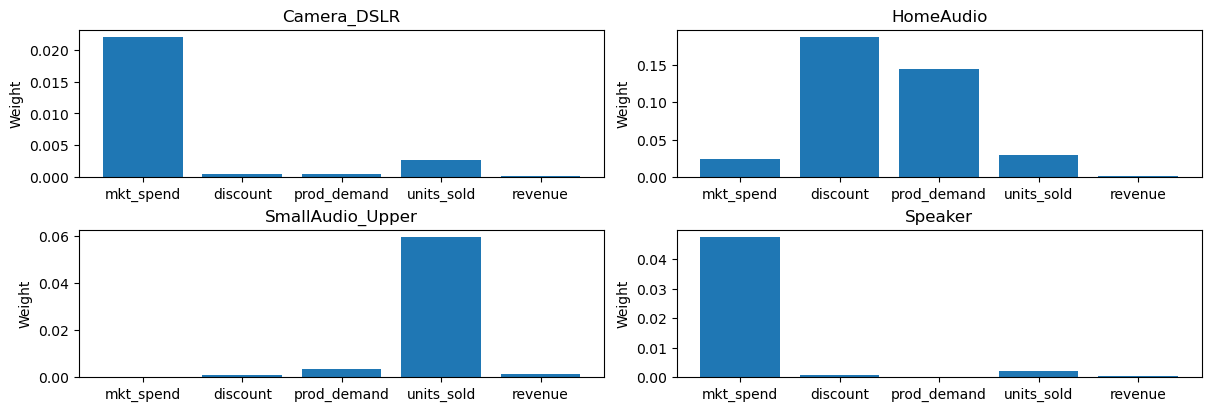

In [96]:
fig, axs = plt.subplots(2,2,figsize=(12,4),layout='constrained')


targets = zip([key for key in icc_ovl.keys() if key in ('Camera_DSLR','HomeAudio','Speaker','SmallAudio_Upper')], axs.flatten())
columns = list(icc_ovl['HomeAudio'].keys())

for i, (name,ax) in enumerate(targets):
    ax.set_title(name)
    ax.bar(x=['mkt_spend','discount','prod_demand','units_sold','revenue'],height=icc_ovl[name].values())
    ax.set_ylabel('Weight')

In [11]:
f = pd.DataFrame(icc_agg_dict)

Text(0.5, 1.0, 'Avg Contribution of each feature to total revenue')

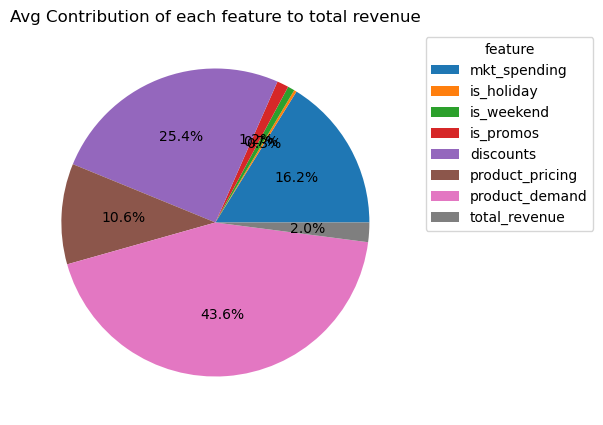

In [58]:
fig, ax = plt.subplots(figsize=(5,5))    

wedge, text, atxt = ax.pie((f/f.sum()).transpose().mean(),autopct='%2.1f%%')
    
ax.legend(wedge, ['mkt_spending','is_holiday','is_weekend','is_promos','discounts',
                 'product_pricing','product_demand','total_revenue'],
          title="feature",
          bbox_to_anchor=(1, 0, 0.5, 1)
         )

ax.set_title('Avg Contribution of each feature to total revenue')

In [107]:
marketing_data['Date'] = pd.to_datetime(marketing_data['Date'] )

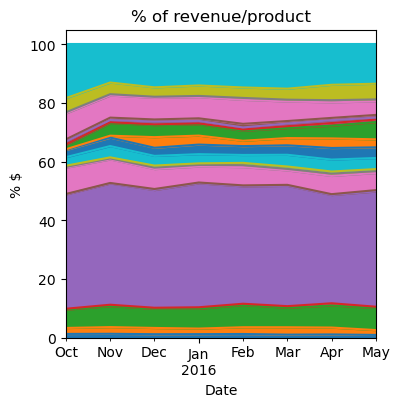

In [121]:
ax = (marketing_data[category_columns+['Date']].set_index('Date').divide(
    marketing_data[category_columns+['Date']].set_index('Date').sum(axis=1),axis=0)
*100).plot(kind='area',figsize=(4,4),title='% of revenue/product',ylabel='% $',legend=False)



In [20]:
causal_graph = nx.DiGraph([
                          ('pricing','units_sold'),('pricing','revenue'), ('on_promos','discount'),
                        ('mkt_spend','units_sold'),('mkt_spend','pricing'),
                           ('discount','units_sold'),('discount','revenue'),
                           ('is_holiday','units_sold'),('is_holiday','pricing'),
                           ('is_weekend','units_sold'),('is_weekend','pricing'),
                           ('units_sold','revenue'),
                           ('on_promos','pricing'),('is_holiday','on_promos'), 
                          ])

In [21]:
model = CausalModel(
   data=pd.DataFrame(), # some pandas dataframe
   treatment="ttl_investment",
   outcome="gmv_new",
   graph="\n".join(nx.generate_gml(causal_graph))
)

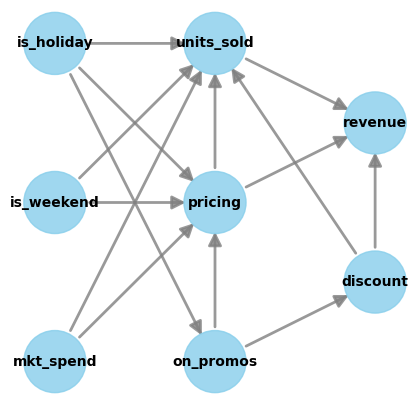

In [25]:
model.view_model(size=(5,5))